# Common imports

In [1]:
import sys
sys.path.append("..")
from evaluate import (
    calculate_scores,
    find_opt_thresh,
    find_opt_thresh_2D,
    calculate_metrics,
    find_intervals,
    calculate_gnnet_scores
)

import os
import random
from multiprocessing import get_context
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from tabulate import tabulate
from IPython.display import display, Markdown
from fastdtw import fastdtw

from dataclasses import dataclass
@dataclass
class Metrics:
    y: torch.Tensor
    y_hat: torch.Tensor
    alphas: torch.Tensor
    MRE: float
    MSE: float
    MAE: float
    RSE: float


def detect_anomalous_intervals(ground_truth, predictions, T):
    interval_predictions = predictions.clone()
    detected_intervals = 0

    if len(ground_truth.shape) == 1:
        start = None
        for i in range(ground_truth.shape[0]):
            if ground_truth[i].item() == 1 and start is None:
                start = i
            elif ground_truth[i].item() == 0 and start is not None:
                end = i
                detected_samples = predictions[start:end].sum().item()
                if detected_samples >= T:
                    interval_predictions[start:end] = 1
                    detected_intervals += 1
                start = None

        if start is not None:
            end = ground_truth.shape[0]
            detected_samples = predictions[start:end].sum().item()
            if detected_samples >= T:
                interval_predictions[start:end] = 1
                detected_intervals += 1

        return detected_intervals, interval_predictions

    if len(ground_truth.shape) == 2:
        for node_idx in range(ground_truth.shape[0]):
            start = None
            for i in range(ground_truth.shape[1]):
                if ground_truth[node_idx, i].item() == 1 and start is None:
                    start = i
                elif ground_truth[node_idx, i].item() == 0 and start is not None:
                    end = i
                    detected_samples = predictions[node_idx, start:end].sum().item()
                    if detected_samples >= T:
                        interval_predictions[node_idx, start:end] = 1
                        detected_intervals += 1
                    start = None

            if start is not None:
                end = ground_truth.shape[1]
                detected_samples = predictions[node_idx, start:end].sum().item()
                if detected_samples >= T:
                    interval_predictions[node_idx, start:end] = 1
                    detected_intervals += 1

        return detected_intervals, interval_predictions


def parse_gnnet_format(data_path):
    @dataclass
    class Metrics:
        y: torch.Tensor
        y_hat: torch.Tensor
        alphas: torch.Tensor
        incoming_paths: torch.Tensor
        MRE: float
        MSE: float
        MAE: float
        RSE: float

    @dataclass
    class NewRes:
        y: torch.Tensor
        y_hat: torch.Tensor

    # to convert gnnet model data format to our format
    data = torch.load(data_path, map_location=torch.device("cpu"))
    train_y, train_y_hat = [], []
    for key in data["train"]:
        train_y.append(data["train"][key].y)
        train_y_hat.append(data["train"][key].y_hat)
    test_y, test_y_hat = [], []
    for key in data["test"]:
        test_y.append(data["test"][key].y)
        test_y_hat.append(data["test"][key].y_hat)
    new_data = dict(
        train=NewRes(y=torch.stack(train_y), y_hat=torch.stack(train_y_hat)),
        test=NewRes(y=torch.stack(test_y), y_hat=torch.stack(test_y_hat)),
    )
    return new_data


# 1) WaDi: Classification performance

## 1.1) Find optim parameters

In [2]:
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = GAT_ADp["metadata"]["window_size"]
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat

wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:]

# max_f1 = 0
# optim_eps = 0
# for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
#     GAT_ADp_scores = calculate_scores(model_y=GAT_ADp_y, model_y_hat=GAT_ADp_y_hat, metric="MAE", eps=eps)
#     optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=GAT_ADp_scores, ground_truth_labels=wadi_labels, num_iters=2000)
#     GAT_ADp_detections = GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
#     precision, recall, f1 = calculate_metrics(ground_truth=wadi_labels, predictions=GAT_ADp_detections)
#     if f1 > max_f1:
#         max_f1 = f1
#         optim_eps = eps

# print(f"Model GAT-AD+ Optim eps: {optim_eps} (F1={max_f1:.2f}%)")

window_size = GAT_ADp["metadata"]["window_size"]
gnnet = parse_gnnet_format("pth_files/evaluation/1_classif_performance/GNNet_WADI.pth")
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=wadi_labels, num_iters=5000, topk=1)
print(f"Model GNNet optim topk: {optim_topk} optim thresh: {optim_thresh} (F1={f1:.2f}%)")

Model GNNet optim topk: 1 optim thresh: 107507.5625 (F1=26.82%)


## 1.2) Run with optim parameters

In [2]:
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = GAT_ADp["metadata"]["window_size"]
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat

wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:]

table_data = []
T = 1
GAT_ADp_scores = calculate_scores(model_y=GAT_ADp_y, model_y_hat=GAT_ADp_y_hat, metric="MAE", eps=0.05)
optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=GAT_ADp_scores, ground_truth_labels=wadi_labels, num_iters=5000)
GAT_ADp_detections = GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=GAT_ADp_detections, return_accuracy=True)
table_data.append(["GAT-AD+", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=GAT_ADp_detections, T=T)
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections, return_accuracy=True)
table_data.append(["GAT-AD+ (intervals)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
detections = dict(detections=GAT_ADp_detections, threshold=optim_thresh, topk=optim_topk, metric="MAE", eps=0.05, scores=GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0))
torch.save(GAT_ADp_detections, "pth_files/evaluation/2_overlap_analysis/GAT_ADp_detections.pth")
torch.save(dict(scores=GAT_ADp_scores, topk=optim_topk, threshold=optim_thresh), "pth_files/evaluation/2_overlap_analysis/GAT_ADp_scores.pth")
torch.save(interval_detections, "pth_files/evaluation/2_overlap_analysis/GAT_ADp_interval_detections.pth")

GDN_detections = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_pred_labels.pth")[window_size - 5:])
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=GDN_detections, return_accuracy=True)
table_data.append(["GDN", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=GDN_detections, T=T)
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections, return_accuracy=True)
table_data.append(["GDN (intervals)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
torch.save(interval_detections, "pth_files/evaluation/2_overlap_analysis/GDN_interval_detections.pth")

window_size = GAT_ADp["metadata"]["window_size"]
gnnet = parse_gnnet_format("pth_files/evaluation/1_classif_performance/GNNet_WADI.pth")
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=wadi_labels, num_iters=5000, topk=1)
GNNet_detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=GNNet_detections, return_accuracy=True)
table_data.append(["GNNet", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=GNNet_detections, T=T)
torch.save(GNNet_detections, "pth_files/evaluation/2_overlap_analysis/GNNet_detections.pth")
torch.save(interval_detections, "pth_files/evaluation/2_overlap_analysis/GNNet_interval_detections.pth")
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections, return_accuracy=True)
table_data.append(["GNNet (intervals)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])

latex_table = tabulate(table_data, headers=["Model", "Precision", "Recall", "F1", "Accuracy"], tablefmt="pipe")
display(Markdown(latex_table))

# print(tabulate(table_data, headers=["Model", "Precision", "Recall", "F1"], tablefmt="latex"))

| Model               | Precision   | Recall   | F1     | Accuracy   |
|:--------------------|:------------|:---------|:-------|:-----------|
| GAT-AD+             | 81.87%      | 45.33%   | 58.36% | 96.29%     |
| GAT-AD+ (intervals) | 86.69%      | 65.42%   | 74.57% | 97.44%     |
| GDN                 | 82.13%      | 35.90%   | 49.96% | 95.87%     |
| GDN (intervals)     | 86.79%      | 51.32%   | 64.50% | 96.76%     |
| GNNet               | 98.71%      | 15.52%   | 26.82% | 95.14%     |
| GNNet (intervals)   | 98.74%      | 15.92%   | 27.42% | 95.16%     |

# 2) WaDi: Overlap analysis

## 2.1) Check which anomalies are detected by GAT-AD+ and not by GDN

Number of GAT-AD+ detections overlapping with GDN detections: 52.75%
Number of GAT-AD+ interval detections overlapping with GDN interval detections: 70.16%


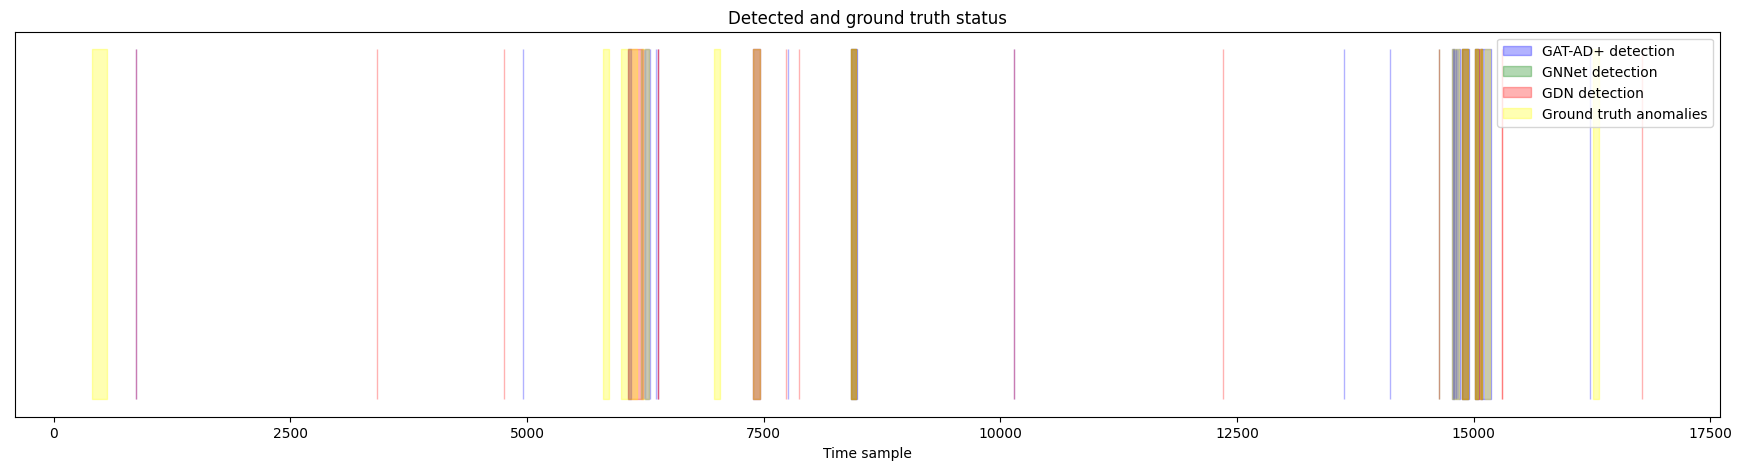

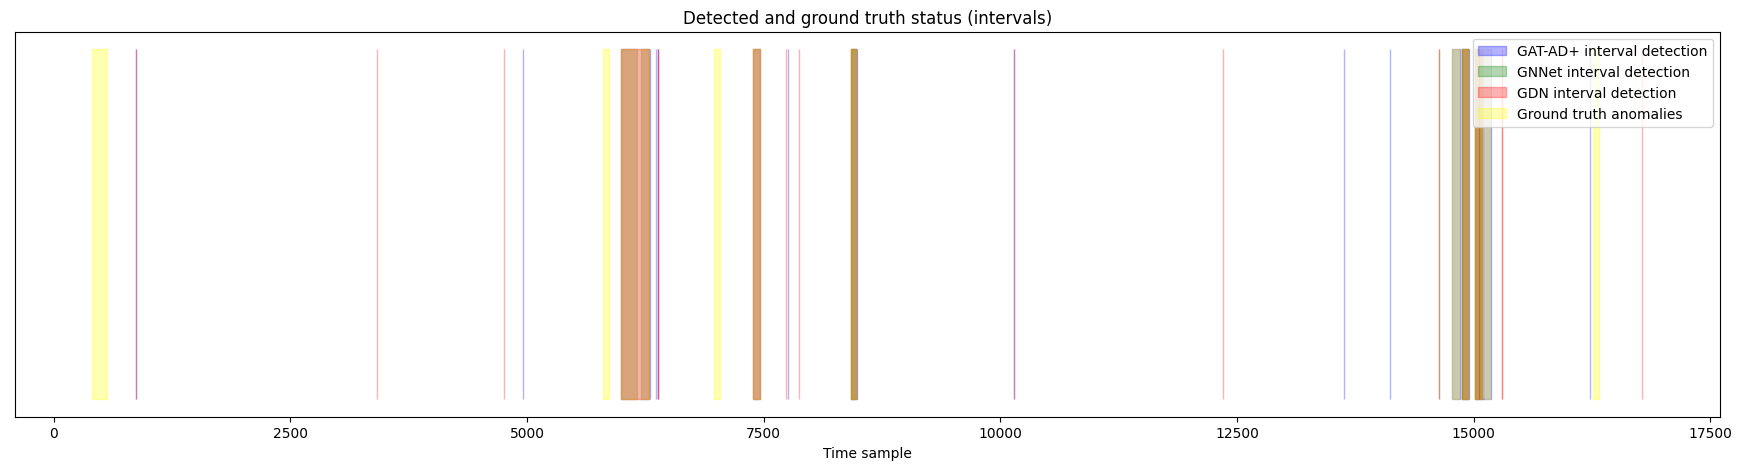

| Anomaly ID                | Interval       | GAT-AD+ Detection   | GDN Detection   | GNNet detection   |
|:--------------------------|:---------------|:--------------------|:----------------|:------------------|
| 1 (Attack identifier 1)   | (410, 561)     | False               | False           | False             |
| 2 (Attack identifier 2)   | (5805, 5863)   | False               | False           | False             |
| 3 (Attack identifier 4)   | (5990, 6163)   | True                | True            | False             |
| 4 (Attack identifier 5)   | (6204, 6288)   | True                | True            | False             |
| 5 (Attack identifier 6)   | (6977, 7043)   | False               | False           | False             |
| 6 (Attack identifier 7)   | (7390, 7459)   | True                | True            | False             |
| 7 (Attack identifier 8)   | (8420, 8477)   | True                | True            | True              |
| 8 (Attack identifier 10)  | (14767, 14847) | True                | False           | False             |
| 9 (Attack identifier 11)  | (14879, 14941) | True                | True            | True              |
| 10 (Attack identifier 12) | (15014, 15049) | True                | True            | True              |
| 11 (Attack identifier 13) | (15065, 15084) | True                | True            | True              |
| 12 (Attack identifier 14) | (15116, 15173) | True                | False           | False             |
| 13 (Attack identifier 15) | (16259, 16321) | False               | False           | False             |

In Abilene, there are a total of 14 anomalies. Due to the 1/10 downsampling, one of them is lost!!! 😅


In [49]:
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat
num_nodes = GAT_ADp_y.shape[0]
window_size = GAT_ADp["metadata"]["window_size"]
GDN_test_y_hat = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[0]  # GDN uses a window size = 5
GDN_test_y_hat = torch.tensor(GDN_test_y_hat[window_size - 5:]).T
GDN_test_y = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[1]  # GDN uses a window size = 5
GDN_test_y = torch.tensor(GDN_test_y[window_size - 5:]).T

GAT_ADp_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_detections.pth").long()
GAT_ADp_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_interval_detections.pth").long()
GDN_detections = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_pred_labels.pth")[window_size - 5:]).long()
GDN_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_interval_detections.pth").long()
GNNet_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GNNet_detections.pth")
GNNet_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GNNet_interval_detections.pth")
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:].long()
wadi_node_indices = torch.load("../../dataset/WADI/processed.pth")["node_indices"]
wadi_index_to_name = {v: k for k, v in wadi_node_indices.items()}

print(f"Number of GAT-AD+ detections overlapping with GDN detections: {(GAT_ADp_detections & GDN_detections).nonzero().shape[0] * 100 / GAT_ADp_detections.nonzero().shape[0]:.2f}%")
print(f"Number of GAT-AD+ interval detections overlapping with GDN interval detections: {(GAT_ADp_interval_detections & GDN_interval_detections).nonzero().shape[0] * 100 / GAT_ADp_interval_detections.nonzero().shape[0]:.2f}%")

plt.figure(figsize=(22, 5))
time_axis = torch.arange(len(GAT_ADp_detections))
plt.fill_between(time_axis, 0, 1, where=GAT_ADp_detections == 1, color='blue', alpha=0.3, label="GAT-AD+ detection")
plt.fill_between(time_axis, 0, 1, where=GNNet_detections == 1, color='green', alpha=0.3, label="GNNet detection")
plt.fill_between(time_axis, 0, 1, where=GDN_detections == 1, color='red', alpha=0.3, label="GDN detection")
plt.fill_between(time_axis, 0, 1, where=wadi_labels == 1, color='yellow', alpha=0.3, label="Ground truth anomalies")
plt.xlabel('Time sample')
plt.ylabel('Network status')
plt.title('Detected and ground truth status')
plt.gca().axes.get_yaxis().set_visible(False)  # hide y-axis labels
plt.legend()
plt.show()

plt.figure(figsize=(22, 5))
time_axis = torch.arange(len(GAT_ADp_detections))
plt.fill_between(time_axis, 0, 1, where=GAT_ADp_interval_detections == 1, color='blue', alpha=0.3, label="GAT-AD+ interval detection")
plt.fill_between(time_axis, 0, 1, where=GNNet_interval_detections == 1, color='green', alpha=0.3, label="GNNet interval detection")
plt.fill_between(time_axis, 0, 1, where=GDN_interval_detections == 1, color='red', alpha=0.3, label="GDN interval detection")
plt.fill_between(time_axis, 0, 1, where=wadi_labels == 1, color='yellow', alpha=0.3, label="Ground truth anomalies")
plt.xlabel('Time sample')
plt.ylabel('Network status')
plt.title('Detected and ground truth status (intervals)')
plt.gca().axes.get_yaxis().set_visible(False)  # hide y-axis labels
plt.legend()
plt.show()

GAT_ADp_nonoverlap_GDN = GAT_ADp_detections & ~GDN_detections
anomalous_intervals = find_intervals(wadi_labels)
GAT_ADp_detected_intervals = {i: False for i in range(len(anomalous_intervals))}  # To check which of the anomalous intervals have been detected by GAT-AD+
GDN_detected_intervals = {i: False for i in range(len(anomalous_intervals))}  # To check which of the anomalous intervals have been detected by GDN
GNNet_detected_intervals = {i: False for i in range(len(anomalous_intervals))}  # To check which of the anomalous intervals have been detected by GNNet
original_anom_to_dataset_id = {1: 0, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: None, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 15: 12}  # map dataset anomaly ID -> anomalous_intervals array position
dataset_anom_id_to_original_anom = {v: k for k, v in original_anom_to_dataset_id.items()}
for anomaly_id, (anomaly_start, anomaly_end) in enumerate(anomalous_intervals):
    if GAT_ADp_detections[anomaly_start:anomaly_end].nonzero().shape[0] > 0:
        GAT_ADp_detected_intervals[anomaly_id] = True
    if GDN_detections[anomaly_start:anomaly_end].nonzero().shape[0] > 0:
        GDN_detected_intervals[anomaly_id] = True
    if GNNet_detections[anomaly_start:anomaly_end].nonzero().shape[0] > 0:
        GNNet_detected_intervals[anomaly_id] = True
table_data = []
for (anomaly_start, anomaly_end), (key, GAT_ADp_anomaly_status), (_, GDN_anomaly_status), (_, GNNet_anomaly_status) in zip(anomalous_intervals, GAT_ADp_detected_intervals.items(), GDN_detected_intervals.items(), GNNet_detected_intervals.items()):
    table_data.append([f"{key + 1} (Attack identifier {dataset_anom_id_to_original_anom[key]})", (anomaly_start, anomaly_end), GAT_ADp_anomaly_status, GDN_anomaly_status, GNNet_anomaly_status])  # weird people do not count from 0
latex_table = tabulate(table_data, headers=["Anomaly ID", "Interval", "GAT-AD+ Detection", "GDN Detection", "GNNet detection"], tablefmt="pipe")
display(Markdown(latex_table))
print(f"In Abilene, there are a total of 14 anomalies. Due to the 1/10 downsampling, one of them is lost!!! 😅")

## 2.2) Visualization of anomalies detected by GAT-AD+ and not by GDN

In [11]:
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat
num_nodes = GAT_ADp_y.shape[0]
window_size = GAT_ADp["metadata"]["window_size"]
GDN_test_y_hat = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[0]  # GDN uses a window size = 5
GDN_test_y_hat = torch.tensor(GDN_test_y_hat[window_size - 5:]).T
GDN_test_y = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[1]  # GDN uses a window size = 5
GDN_test_y = torch.tensor(GDN_test_y[window_size - 5:]).T

GAT_ADp_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_detections.pth").long()
GAT_ADp_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_interval_detections.pth").long()
GDN_detections = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_pred_labels.pth")[window_size - 5:]).long()
GDN_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_interval_detections.pth").long()
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:].long()
wadi_node_indices = torch.load("../../dataset/WADI/processed.pth")["node_indices"]
wadi_index_to_name = {v: k for k, v in wadi_node_indices.items()}

GAT_ADp_nonoverlap_GDN = GAT_ADp_detections & ~GDN_detections
intervals = find_intervals(GAT_ADp_nonoverlap_GDN)
anomalous_intervals = find_intervals(wadi_labels)
GAT_ADp_detected_intervals = {i: False for i in range(len(anomalous_intervals))}  # To check which of the anomalous intervals have been detected by GAT-AD+
GDN_detected_intervals = {i: False for i in range(len(anomalous_intervals))}  # To check which of the anomalous intervals have been detected by GDN
for anomaly_id, (anomaly_start, anomaly_end) in enumerate(anomalous_intervals):
    if GAT_ADp_detections[anomaly_start:anomaly_end].nonzero().shape[0] > 0:
        GAT_ADp_detected_intervals[anomaly_id] = True
    if GDN_detections[anomaly_start:anomaly_end].nonzero().shape[0] > 0:
        GDN_detected_intervals[anomaly_id] = True

GAT_ADp_only_detected_intervals = dict()  # set to True only the anomalous intervals detected by GAT-AD+ and not by GDN
for interval_id, status in GAT_ADp_detected_intervals.items():
    if GDN_detected_intervals[interval_id] is True:
        GAT_ADp_only_detected_intervals[interval_id] = False
    else:
        GAT_ADp_only_detected_intervals[interval_id] = status

original_anom_to_dataset_id = {1: 0, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: None, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 15: 12}  # map dataset anomaly ID -> anomalous_intervals array position
dataset_anom_id_to_original_anom = {v: k for k, v in original_anom_to_dataset_id.items()}

print(f"Detected anomalies by GAT-AD+ not detected by GDN: {[dataset_anom_id_to_original_anom[anom_id] for anom_id, status in GAT_ADp_only_detected_intervals.items() if status is True]} corresponding to samples {[anomalous_intervals[anom_id] for anom_id, status in GAT_ADp_only_detected_intervals.items() if status is True]}")


def plot_time_series(GAT_ADp_test_y, GAT_ADp_test_y_hat, GDN_test_y_hat, wadi_labels, nodes_to_plot_indices, wadi_index_to_name, plot_start, plot_end):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_test_y_subset = GAT_ADp_test_y[:, plot_start:plot_end + 1]
    GAT_ADp_test_y_hat_subset = GAT_ADp_test_y_hat[:, plot_start:plot_end + 1]
    GDN_test_y_hat_subset = GDN_test_y_hat[:, plot_start:plot_end + 1]
    wadi_labels_subset = wadi_labels[plot_start:plot_end + 1]

    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots), sharex=True)

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax, node_idx in zip(axs, nodes_to_plot_indices):
        y_true = GAT_ADp_test_y_subset[node_idx].cpu().numpy()
        y_hat_gat = GAT_ADp_test_y_hat_subset[node_idx].cpu().numpy()
        y_hat_gdn = GDN_test_y_hat_subset[node_idx].cpu().numpy()

        # Plot the node data
        ax.plot(adjusted_time_range, y_true, label='Ground truth', color='blue')
        ax.plot(adjusted_time_range, y_hat_gat, label='GAT-AD+ y_hat', color='green')
        ax.plot(adjusted_time_range, y_hat_gdn, label='GDN_test y_hat', color='red')

        # Highlight the background for label == 1
        for i in adjusted_time_range:
            if wadi_labels_subset[i] == 1:
                ax.axvspan(i, i + 1, color='lightcoral', alpha=0.3)

        ax.set_ylabel(f'Node {wadi_index_to_name[node_idx]}')
        ax.legend(loc='upper right')
        ax.grid(True)

    axs[-1].set_xlabel('Sample')
    plt.tight_layout()
    plt.show()


def plot_time_series_ground_truth(GAT_ADp_test_y, wadi_labels, nodes_to_plot_indices, wadi_index_to_name, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_test_y_subset = GAT_ADp_test_y[:, plot_start:plot_end + 1]
    wadi_labels_subset = wadi_labels[plot_start:plot_end + 1]

    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2.8 * num_plots), sharex=True)

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax, node_idx in zip(axs, nodes_to_plot_indices):
        y_true = GAT_ADp_test_y_subset[node_idx].cpu().numpy()

        # Plot the node data
        ax.plot(adjusted_time_range, y_true, label='Ground truth', color='black')

        # Highlight the background for label == 1
        contiguous_regions = []
        in_region = False
        region_start = 0

        for i in adjusted_time_range:
            if wadi_labels_subset[i] == 1 and not in_region:
                in_region = True
                region_start = i
            elif wadi_labels_subset[i] == 0 and in_region:
                in_region = False
                contiguous_regions.append((region_start, i))

        if in_region:  # If the last region goes till the end
            contiguous_regions.append((region_start, adjusted_time_range[-1] + 1))

        # Highlight the background for contiguous label == 1 regions
        for start, end in contiguous_regions:
            ax.axvspan(start, end, color='grey', alpha=0.3)

        ax.set_ylabel(f'Node value')
        # ax.legend(loc='upper right')
        # ax.grid(True)

    axs[-1].set_xlabel('Sample')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_time_series_scores(GAT_ADp_scores, GDN_scores, wadi_labels, nodes_to_plot_indices, wadi_index_to_name, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_range_score = GAT_ADp_scores[:, plot_start:plot_end + 1]
    GDN_range_score = GDN_scores[:, plot_start:plot_end + 1]
    wadi_labels_subset = wadi_labels[plot_start:plot_end + 1]

    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots), sharex=True)

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax, node_idx in zip(axs, nodes_to_plot_indices):
        score_gat = GAT_ADp_range_score[node_idx].cpu().numpy()
        score_gdn = GDN_range_score[node_idx].cpu().numpy()

        # Plot the node data
        ax.plot(adjusted_time_range, score_gat, label='GAT-AD+ score', color='green')
        ax.plot(adjusted_time_range, score_gdn, label='GDN score', color='red')

        # Highlight the background for label == 1
        for i in adjusted_time_range:
            if wadi_labels_subset[i] == 1:
                ax.axvspan(i, i + 1, color='lightcoral', alpha=0.3)

        ax.set_ylabel(f'Node {wadi_index_to_name[node_idx]}')
        ax.legend(loc='upper right')
        ax.grid(True)

    axs[-1].set_xlabel('Sample')
    plt.tight_layout()
    plt.title("Model anomaly scores")
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_global_score(scores, thresholds, wadi_labels, models, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    wadi_labels_subset = wadi_labels[plot_start:plot_end + 1]

    plt.figure(figsize=(10, 4))
    ax = plt.gca()

    # Define different linestyles
    linestyles = ['--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]  # Extend this list if needed

    # Plot each score series normalized by its corresponding threshold
    for idx, (score, threshold, model) in enumerate(zip(scores, thresholds, models)):
        scores_subset = score[plot_start:plot_end + 1]
        normalized_scores = scores_subset / threshold
        ax.plot(adjusted_time_range, normalized_scores, label=f'{model} scores', linestyle=linestyles[idx % len(linestyles)], color='black')

    # Highlight the background for label == 1
    contiguous_regions = []
    in_region = False
    region_start = 0

    for i in adjusted_time_range:
        if wadi_labels_subset[i] == 1 and not in_region:
            in_region = True
            region_start = i
        elif wadi_labels_subset[i] == 0 and in_region:
            in_region = False
            contiguous_regions.append((region_start, i))
    if in_region:
        contiguous_regions.append((region_start, adjusted_time_range[-1] + 1))

    for start, end in contiguous_regions:
        ax.axvspan(start, end, color='grey', alpha=0.3)

    # Add a horizontal line for the threshold
    ax.axhline(y=1, color='black', linestyle='-', label='Threshold')

    # Set plot labels and title with increased font sizes
    ax.set_xlabel('Sample', fontsize=12)
    ax.set_ylabel('Scores', fontsize=12)
    ax.legend(loc='upper right', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_alphas(GAT_ADp_alphas, nodes_to_plot_indices, wadi_index_to_name, plot_start, plot_end, save_path=None):
    GAT_ADp_range_alphas_before = GAT_ADp_alphas[plot_start-100:plot_start, :, :]
    GAT_ADp_range_alphas_during = GAT_ADp_alphas[plot_start:plot_end, :, :]
    GAT_ADp_range_alphas_after = GAT_ADp_alphas[plot_end:plot_end+100, :, :]
    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 3, figsize=(30, 5 * num_plots))

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax_set, node_idx in zip(axs, nodes_to_plot_indices):
        for ax, context, title in zip(ax_set, [GAT_ADp_range_alphas_before, GAT_ADp_range_alphas_during, GAT_ADp_range_alphas_after],
                                      ["Context before the anomaly", "Context during the anomaly", "Context after the anomaly"]):
            node_alphas_values, node_alphas_indices = context[:, node_idx, :].mean(dim=0).sort(descending=True)
            node_alphas_values = node_alphas_values[:7].numpy()
            node_alphas_indices = [wadi_index_to_name[index] for index in node_alphas_indices[:7].numpy()]

            ax.bar(node_alphas_indices, node_alphas_values)
            ax.set_xticks(range(len(node_alphas_indices)))
            ax.set_xticklabels(node_alphas_indices, rotation=0, fontsize=9)
            ax.set_ylabel('Attention score', fontsize=12)
            ax.tick_params(axis='y', which='major', labelsize=12)
            ax.grid(False)  # Disable the grid
            ax.set_title(title, fontsize=12)

    if save_path:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()


def plot_force_graph(GAT_ADp_alphas, nodes_to_plot_indices, wadi_index_to_name, plot_start, plot_end, save_path=None):
    import networkx as nx
    GAT_ADp_range_alphas_before = GAT_ADp_alphas[plot_start-50:plot_start, :, :]
    GAT_ADp_range_alphas_during = GAT_ADp_alphas[plot_start:plot_end, :, :]
    GAT_ADp_range_alphas_after = GAT_ADp_alphas[plot_end:plot_end+50, :, :]
    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 3, figsize=(30, 5 * num_plots))

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax_set, node_idx in zip(axs, nodes_to_plot_indices):
        for ax, context, title in zip(ax_set, [GAT_ADp_range_alphas_before, GAT_ADp_range_alphas_during, GAT_ADp_range_alphas_after],
                                      ["Context before the anomaly", "Context during the anomaly", "Context after the anomaly"]):
            # Create a directed graph
            G = nx.DiGraph()
            node_alphas_values, node_alphas_indices = context[:, node_idx, :].mean(dim=0).sort(descending=True)
            node_alphas_values = node_alphas_values.numpy()
            node_alphas_indices = node_alphas_indices.numpy()

            # Add nodes and edges to the graph
            for index, value in zip(node_alphas_indices, node_alphas_values):
                if value > 0.05:  # Filter edges with attention coefficients greater than 0.05
                    source = wadi_index_to_name[node_idx]
                    target = wadi_index_to_name[index]
                    G.add_edge(source, target, weight=value)

            # Draw the graph
            pos = nx.spring_layout(G)
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='skyblue', node_size=3000, edge_color='black', linewidths=1, font_size=12)
            edge_labels = nx.get_edge_attributes(G, 'weight')
            edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

            ax.set_title(title, fontsize=12)

    if save_path:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

Detected anomalies by GAT-AD+ not detected by GDN: [10, 14] corresponding to samples [(14767, 14847), (15116, 15173)]


### 2.2.1) Attack ID 10
Damage on 1_MV_001 and raw water pump to drain Elevated Reservoir tank

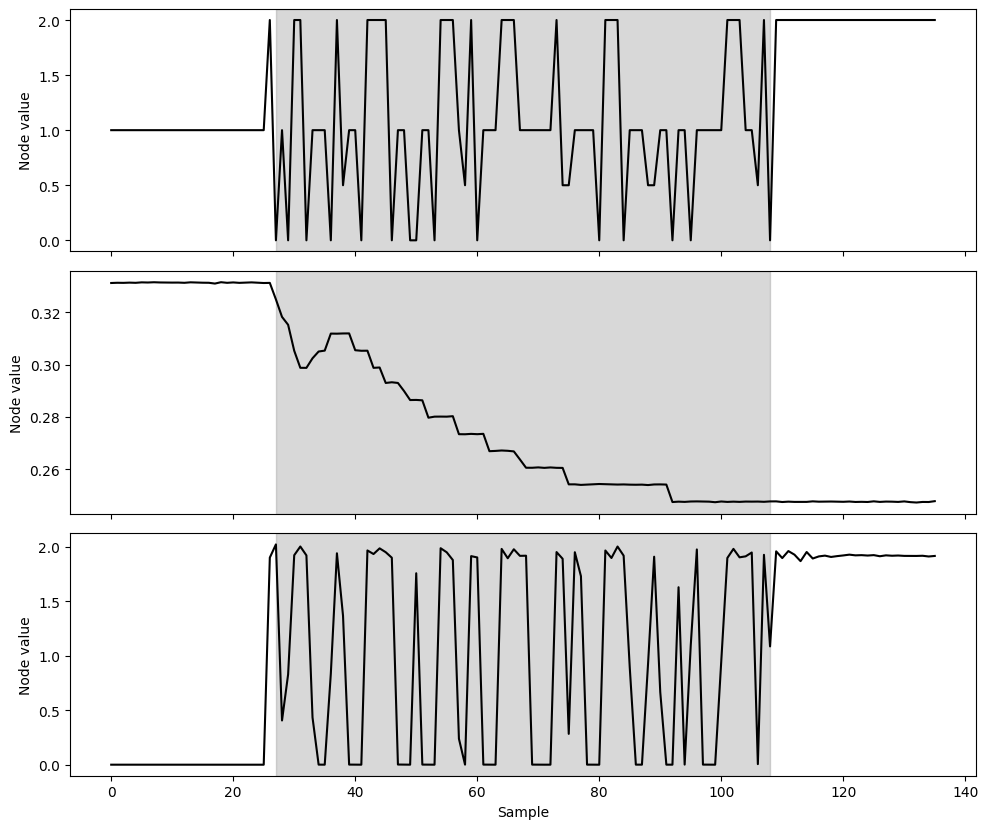

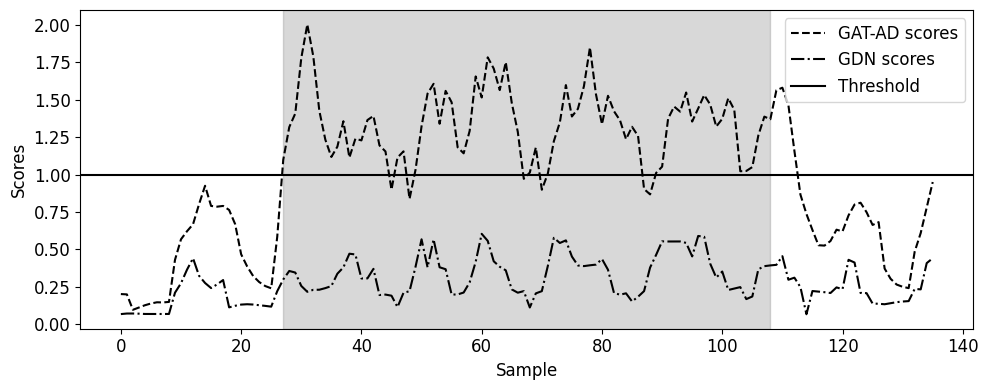

In [12]:
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat
num_nodes = GAT_ADp_y.shape[0]
window_size = GAT_ADp["metadata"]["window_size"]
GDN_test_y_hat = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[0]  # GDN uses a window size = 5
GDN_test_y_hat = torch.tensor(GDN_test_y_hat[window_size - 5:]).T
GDN_test_y = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_result.pth")[1]  # GDN uses a window size = 5
GDN_test_y = torch.tensor(GDN_test_y[window_size - 5:]).T

WADI_notnorm = torch.load("../../dataset/WADI/processed_notnorm.pth")["test"][:, window_size:]

GAT_ADp_scores = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_scores.pth")["scores"]
GAT_ADp_threshold = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_scores.pth")["threshold"]
GAT_ADp_topk = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_scores.pth")["topk"]
GAT_ADp_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_detections.pth").long()
GAT_ADp_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GAT_ADp_interval_detections.pth").long()
GDN_detections = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_pred_labels.pth")[window_size - 5:]).long()
GDN_interval_detections = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_interval_detections.pth").long()
GDN_pred_labels = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_pred_labels.pth"))[window_size - 5:].long()
GDN_scores = torch.tensor(torch.load("pth_files/evaluation/2_overlap_analysis/GDN_test_scores.pth"))[:, window_size - 5:]
GDN_threshold = torch.load("pth_files/evaluation/2_overlap_analysis/GDN_top1_best_info.pth")[-1]
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:].long()

GNNet = parse_gnnet_format("pth_files/evaluation/1_classif_performance/GNNet_WADI.pth")
GNNet_scores = calculate_gnnet_scores(GNNet["train"].y, GNNet["train"].y_hat, GNNet["test"].y, GNNet["test"].y_hat)[:, window_size:]
GNNet_threshold = 107507.5625


wadi_node_indices = torch.load("../../dataset/WADI/processed.pth")["node_indices"]
wadi_index_to_name = {v: k for k, v in wadi_node_indices.items()}

nodes_to_plot = ["1_MV_001_STATUS", "1_AIT_005_PV", "1_FIT_001_PV"]
# nodes_to_plot = ["1_MV_001_STATUS", "1_AIT_005_PV", "1_FIT_001_PV", "2_DPIT_001_PV", "2_FIC_301_PV", "2_FIC_201_PV", "2_FIT_002_PV"]
nodes_to_plot_other_anom_included = ["1_MV_001_STATUS", "1_AIT_005_PV", "1_FIT_001_PV", "2_DPIT_001_PV", "2_FIC_301_PV", "2_FIC_201_PV", "2_FIT_002_PV"]
# nodes_to_plot = list(wadi_node_indices.keys())
nodes_to_plot_indices = [wadi_node_indices[node] for node in nodes_to_plot]
plot_start, plot_end = 14740, 14875

plot_time_series_ground_truth(GAT_ADp_test_y=WADI_notnorm, wadi_labels=wadi_labels, nodes_to_plot_indices=nodes_to_plot_indices, wadi_index_to_name=wadi_index_to_name, plot_start=plot_start, plot_end=plot_end,
                              save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Attack_10.pdf")
# plot_time_series(GAT_ADp_test_y=GAT_ADp["test"].y, GAT_ADp_test_y_hat=GAT_ADp["test"].y_hat, GDN_test_y_hat=GDN_test_y_hat, wadi_labels=wadi_labels, nodes_to_plot_indices=nodes_to_plot_indices, wadi_index_to_name=wadi_index_to_name, plot_start=plot_start, plot_end=plot_end)
# plot_time_series_scores(GAT_ADp_scores=GAT_ADp_scores, GDN_scores=GDN_scores, wadi_labels=wadi_labels, nodes_to_plot_indices=nodes_to_plot_indices, wadi_index_to_name=wadi_index_to_name, plot_start=plot_start, plot_end=plot_end)

# models = ["GAT-AD", "GDN", "GNNet"]
# scores = [GAT_ADp_scores.topk(dim=0, k=GAT_ADp_topk).values.sum(dim=0), GDN_scores.topk(dim=0, k=1).values.sum(dim=0), GNNet_scores.topk(dim=0, k=1).values.sum(dim=0)]
# thresholds = [GAT_ADp_threshold, GDN_threshold, GNNet_threshold]
models = ["GAT-AD", "GDN"]
scores = [GAT_ADp_scores.topk(dim=0, k=GAT_ADp_topk).values.sum(dim=0), GDN_scores.topk(dim=0, k=1).values.sum(dim=0)]
thresholds = [GAT_ADp_threshold, GDN_threshold]

plot_global_score(scores=scores, thresholds=thresholds, models=models, wadi_labels=wadi_labels, plot_start=plot_start, plot_end=plot_end,
                  save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Attack_10_score.pdf")

# plot_alphas(GAT_ADp_alphas=GAT_ADp["test"].alphas, nodes_to_plot_indices=nodes_to_plot_indices, wadi_index_to_name=wadi_index_to_name,
#             plot_start=14767, plot_end=14847)
# plot_force_graph(GAT_ADp_alphas=GAT_ADp["test"].alphas, nodes_to_plot_indices=nodes_to_plot_indices, wadi_index_to_name=wadi_index_to_name,
            # plot_start=14767, plot_end=14847)

# 3) Abilene injected: classification analysis

### 3.1.1) Inject anomalies in Abilene

In [36]:
data = torch.load("../../dataset/Abilene/processed.pth")

flows = data["paths"]
num_nodes = flows.shape[0]
path_indices = {v: k for k, v in data["path_indices"].items()}

def calculate_similarity(args):
    i, data_i, data = args
    node_similarity = []

    # Calculate DTW distance between the current node and all other nodes
    for j, data_j in enumerate(data):
        if i != j:  # Exclude self-similarity
            distance, _ = fastdtw(data_i, data_j)
            node_similarity.append((distance, j))

    # Sort the node similarity list based on DTW distance
    node_similarity.sort()
    return node_similarity

# multiprocessing version
def compute_similarities(data):
    num_nodes = len(data)
    node_similarities = []

    with get_context("fork").Pool() as pool:
        args = [(i, data[i], data) for i in range(num_nodes)]
        node_similarities = list(pool.imap(calculate_similarity, args))

    return node_similarities

def find_most_similar_nodes(data):
    node_similarities = compute_similarities(data)
    most_similar_nodes = []
    for i, node_similarity in enumerate(node_similarities):
        # Select the 3 most similar nodes
        # most_similar = [node[1] for node in node_similarity[:3]]
        # most_similar_nodes.append((i, most_similar, sum(node[0] for node in node_similarity[:3]) / 3))
        # Select the most similar nodes based on the mean
        cut = torch.tensor([similarity for similarity, flow_index in node_similarity])
        flow_indices = torch.tensor([flow_index for similarity, flow_index in node_similarity])
        most_similar_nodes.append((i, flow_indices[cut < cut.mean() / 2].tolist()))

    return most_similar_nodes

def calculate_distances(data, context_size=5):
    node_similarities = compute_similarities(data)
    contexts = dict()
    for src_node, similarities in enumerate(node_similarities):
        similarities = sorted(similarities, key=lambda x: x[0])
        connected_nodes = [node for _, node in similarities[:context_size]]
        contexts[src_node] = connected_nodes

    return contexts

# similarities = dict(find_most_similar_nodes(flows))
# nonempty_similarities = {k: v for k, v in similarities.items() if len(v) > 0}
# print(f"Mean similarity cluster size: {sum([len(v) for k, v in nonempty_similarities.items()]) / len(nonempty_similarities)}")
# print(f"Number of flows with cluster: {len(nonempty_similarities)}       Number of flows with cluster size <= 5: {len({k: v for k, v in nonempty_similarities.items() if len(v) <= 5})}")

abilene = torch.load("../../dataset/Abilene/processed.pth")
test_samples_start, test_samples_end = abilene["paths"].shape[1] // 2, abilene["paths"].shape[1]
subinterval_size = (test_samples_end - test_samples_start) // 80
subintervals = [(test_samples_start + i * subinterval_size, test_samples_start + (i + 1) * subinterval_size) for i in range(80)]
point_anoms = torch.zeros(abilene["paths"].shape)
context_anoms = torch.zeros(abilene["paths"].shape)
context_modified_flows = torch.zeros(abilene["paths"].shape)
anomaly_metadata = list()

similarities = find_most_similar_nodes(flows)
flows_with_context = [source for source, context in similarities if len(context) > 0]

for i, (interval_start, interval_end) in enumerate(subintervals):
    duration = random.randint(20, 80)
    magnitude = random.randint(3, 6)
    anom_start = random.randint(interval_start, interval_end - duration)
    anom_end = anom_start + duration
    # gaussian profile
    center = (duration - 1) / 2
    sigma = duration / 6  # Adjust sigma to control the spread of the Gaussian
    x = torch.arange(0, duration)
    gaussian_profile = torch.exp(-0.5 * ((x - center) / sigma) ** 2)
    min_val = magnitude - 1
    max_val = magnitude + 1
    scaled_profile = (gaussian_profile - gaussian_profile.min()) / (gaussian_profile.max() - gaussian_profile.min())
    scaled_profile = scaled_profile * (max_val - min_val) + min_val
    if i % 4 == 1:  # flow anomaly
        source = random.choice(range(num_nodes))
        abilene["paths"][source, anom_start:anom_end] *= scaled_profile
        point_anoms[source, anom_start:anom_end] = torch.ones(duration)
        anomaly_metadata.append(dict(source_flow=source, start=anom_start, end=anom_end, magnitude=magnitude, type=f"Anomaly in source flow"))
    if i % 4 == 3:  # context anomaly
        source = random.choice(flows_with_context)
        area_similarities = find_most_similar_nodes(flows[:, anom_start:anom_end])
        _, context = area_similarities[source]
        if len(context) == 0:
            print(f"Flow {source} has no context in interval {anom_start}-{anom_end}")
        context_anoms[source, anom_start:anom_end] = torch.ones(duration)

        for flow in context:
            abilene["paths"][flow, anom_start:anom_end] *= scaled_profile
            context_modified_flows[flow, anom_start:anom_end] = torch.ones(duration)
        anomaly_metadata.append(dict(source_flow=source, context=context, start=anom_start, end=anom_end, magnitude=magnitude, type=f"Anomaly in context flows"))

abilene["status"] = torch.logical_or(point_anoms, context_anoms).long()
abilene["point_anoms"] = point_anoms.long()
abilene["context_anoms"] = context_anoms.long()
abilene["context_modified_flows"] = context_modified_flows.long()
abilene["anomaly_metadata"] = anomaly_metadata
abilene["comment"] += f". Flow and contextual anomalies injected following the following logic:\n" + \
    "0) Generate a gaussian profile such that the center of it has value magnitude + 1 and the tails have magnitude - 1\n" + \
    "1) Flow anomalies: Select one random flow, inject anomaly with the gaussian profile and duration [20, 80]\n" + \
    "2) Contextual anomalies: Select one flow with context (i.e., len > 0) and inject anomaly into all context with the gaussian profile and duration [20, 80]\n" + \
    "Context definition: [similarity < similarities.mean() / 2]"
# torch.save(abilene, "../../dataset/Abilene/processed_anominj.pth")

In [ ]:
data = torch.load("../../dataset/Abilene/processed.pth")

flows = data["paths"]
num_nodes = flows.shape[0]
path_indices = {v: k for k, v in data["path_indices"].items()}

def calculate_similarity(args):
    i, data_i, data = args
    node_similarity = []

    # Calculate DTW distance between the current node and all other nodes
    for j, data_j in enumerate(data):
        if i != j:  # Exclude self-similarity
            distance, _ = fastdtw(data_i, data_j)
            node_similarity.append((distance, j))

    # Sort the node similarity list based on DTW distance
    node_similarity.sort()
    return node_similarity

# multiprocessing version
def compute_similarities(data):
    num_nodes = len(data)
    node_similarities = []

    with get_context("fork").Pool() as pool:
        args = [(i, data[i], data) for i in range(num_nodes)]
        node_similarities = list(pool.imap(calculate_similarity, args))

    return node_similarities

def find_most_similar_nodes(data):
    node_similarities = compute_similarities(data)
    most_similar_nodes = []
    for i, node_similarity in enumerate(node_similarities):
        # Select the 3 most similar nodes
        # most_similar = [node[1] for node in node_similarity[:3]]
        # most_similar_nodes.append((i, most_similar, sum(node[0] for node in node_similarity[:3]) / 3))
        # Select the most similar nodes based on the mean
        cut = torch.tensor([similarity for similarity, flow_index in node_similarity])
        flow_indices = torch.tensor([flow_index for similarity, flow_index in node_similarity])
        most_similar_nodes.append((i, flow_indices[cut < cut.median() / 2].tolist()))

    return most_similar_nodes

def calculate_distances(data, context_size=5):
    node_similarities = compute_similarities(data)
    contexts = dict()
    for src_node, similarities in enumerate(node_similarities):
        similarities = sorted(similarities, key=lambda x: x[0])
        connected_nodes = [node for _, node in similarities[:context_size]]
        contexts[src_node] = connected_nodes

    return contexts

# similarities = dict(find_most_similar_nodes(flows))
# nonempty_similarities = {k: v for k, v in similarities.items() if len(v) > 0}
# print(f"Mean similarity cluster size: {sum([len(v) for k, v in nonempty_similarities.items()]) / len(nonempty_similarities)}")
# print(f"Number of flows with cluster: {len(nonempty_similarities)}       Number of flows with cluster size <= 5: {len({k: v for k, v in nonempty_similarities.items() if len(v) <= 5})}")

abilene = torch.load("../../dataset/Abilene/processed.pth")
test_samples_start, test_samples_end = abilene["paths"].shape[1] // 2, abilene["paths"].shape[1]
subinterval_size = (test_samples_end - test_samples_start) // 80
subintervals = [(test_samples_start + i * subinterval_size, test_samples_start + (i + 1) * subinterval_size) for i in range(80)]
point_anoms = torch.zeros(abilene["paths"].shape)
context_anoms = torch.zeros(abilene["paths"].shape)
context_modified_flows = torch.zeros(abilene["paths"].shape)
anomaly_metadata = list()
similarities = find_most_similar_nodes(flows)
flows_with_context = [source for source, context in similarities if len(context) > 30]

for i, (interval_start, interval_end) in enumerate(subintervals):
    duration = random.randint(20, 80)
    magnitude = random.randint(2, 5)
    anom_start = random.randint(interval_start, interval_end - duration)
    anom_end = anom_start + duration
    if i % 4 == 1:  # flow anomaly
        source = random.choice(range(num_nodes))
        abilene["paths"][source, anom_start:anom_end] *= magnitude
        point_anoms[source, anom_start:anom_end] = torch.ones(duration)
        anomaly_metadata.append(dict(source_flow=source, start=anom_start, end=anom_end, magnitude=magnitude, type=f"Anomaly in source flow"))
    if i % 4 == 3:  # context anomaly
        source = random.choice(flows_with_context)
        area_similarities = find_most_similar_nodes(flows[:, anom_start:anom_end])
        _, context = area_similarities[source]
        if len(context) == 0:
            print(f"Flow {source} has no context in interval {anom_start}-{anom_end}")
        context_anoms[source, anom_start:anom_end] = torch.ones(duration)
        for flow in context:
            abilene["paths"][flow, anom_start:anom_end] *= magnitude
            context_modified_flows[flow, anom_start:anom_end] = torch.ones(duration)
        anomaly_metadata.append(dict(source_flow=source, context=context, start=anom_start, end=anom_end, magnitude=magnitude, type=f"Anomaly in context flows"))

abilene["status"] = torch.logical_or(point_anoms, context_anoms).long()
abilene["point_anoms"] = point_anoms.long()
abilene["context_anoms"] = context_anoms.long()
abilene["context_modified_flows"] = context_modified_flows.long()
abilene["anomaly_metadata"] = anomaly_metadata
torch.save(abilene, "../../dataset/Abilene/processed_anominj_varflows_2.pth")

### 3.1.2) Visualize generated anomalies

In [ ]:
abilene_anominj = torch.load("../../dataset/Abilene/processed_anominj.pth")
point_inj_anomalies = [(anomaly["source_flow"], anomaly["start"], anomaly["end"]) for anomaly in abilene_anominj["anomaly_metadata"] if anomaly["type"] == "Anomaly in source flow"]
context_inj_anomalies = [(anomaly["source_flow"], anomaly["start"], anomaly["end"], anomaly["context"]) for anomaly in abilene_anominj["anomaly_metadata"] if anomaly["type"] == "Anomaly in context flows"]

total_test_samples = 132 * 23949
total_anom_samples = abilene_anominj["point_anoms"].nonzero().shape[0] + abilene_anominj["context_anoms"].nonzero().shape[0] + abilene_anominj["context_modified_flows"].nonzero().shape[0]
print(f"Percentage of anomalies: {total_anom_samples / total_test_samples * 100:.2f}%")

# for anomaly_id in range(20):
#     source_flow, context, start, end = context_anomalies[anomaly_id]
#     offset = abilene["paths"].shape[1] - anominj_temp_model["test"].y.shape[1]
#     plot_start = start - offset - 40
#     plot_end = end - offset + 40

#     plot_time_series(GAT_ADp_test_y=anominj_temp_model["test"].y, GAT_ADp_test_y_hat=anominj_temp_model["test"].y_hat,
#                     labels=abilene["context_anoms"][:, -anominj_temp_model["test"].y.shape[1]:], nodes_to_plot_indices=[source_flow] + context[0:5],
#                     abilene_index_to_name=abilene_index_to_name, plot_start=plot_start, plot_end=plot_end)

### 3.1.3) Adapt Abilene to GDN

In [18]:
abilene = torch.load("../../dataset/Abilene/processed_anominj.pth")
train = 0.4
test = 0.5

abilene_flows = abilene["paths"]
status = abilene["status"].sum(dim=0) > 0
num_samples = abilene_flows.shape[1]
train_flows = abilene_flows[:, 0:int(num_samples*train)]
indices = torch.arange(train_flows.shape[1]).unsqueeze(0)
zeros_row = torch.zeros((1, train_flows.shape[1]), dtype=train_flows.dtype)
train_flows = torch.cat((indices, train_flows, zeros_row), dim=0)
test_flows = abilene_flows[:, int(num_samples*test):]
test_status = status[int(num_samples*test):].unsqueeze(0)
indices = torch.arange(test_flows.shape[1]).unsqueeze(0)
test_flows = torch.cat((indices, test_flows, test_status), dim=0)
nodes_list = list(abilene["path_indices"])
nodes_list = [f"{node[0]}-{node[1]}" for node in nodes_list]

store_folder = "pth_files/evaluation/3_abilene_classif_performance/abilene_anominj/"
os.makedirs(store_folder, exist_ok=True)
list_path = os.path.join(store_folder, "list.txt")
with open(list_path, "w") as file:
    for node in nodes_list:
        file.write(f"{node}\n")
nodes_list.append("attack")
nodes_list.insert(0, "Unnamed")  # as in wadi dataset
train_df = pd.DataFrame(train_flows.T, columns=nodes_list)
test_df = pd.DataFrame(test_flows.T, columns=nodes_list)
train_csv_path = os.path.join(store_folder, "train.csv")
test_csv_path = os.path.join(store_folder, "test.csv")
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

## 3.2) Find optim parameters

In [4]:
abilene_anominj = torch.load("../../dataset/Abilene/processed_anominj.pth")

anominj_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
anominj_temp_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))

# models = {"GAT-AD+": anominj_model, "GAT-AD+ temp": anominj_temp_model}
models = {"GAT-AD+ temp": anominj_temp_model}

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    abilene_anominj_labels = abilene_anominj["status"][:, -model["test"].y.shape[1]:].long()
    context_anoms = abilene_anominj["context_anoms"][:, -model["test"].y.shape[1]:].long()
    point_anoms = abilene_anominj["point_anoms"][:, -model["test"].y.shape[1]:].long()
    max_f1 = 0
    optim_eps = 0
    for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
        scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps)
        optim_thresh, precision, recall, f1 = find_opt_thresh_2D(scores=scores, ground_truth_labels=abilene_anominj_labels, num_iters=2000)
        detections = scores > optim_thresh
        _, interval_detections = detect_anomalous_intervals(abilene_anominj_labels, (detections & abilene_anominj_labels).long(), T=1)
        precision, recall, f1 = calculate_metrics(ground_truth=abilene_anominj_labels, predictions=(interval_detections & abilene_anominj_labels))
        if f1 > max_f1:
            max_f1 = f1
            optim_eps = eps
    print(f"Model {model_name} optim eps: {optim_eps} optim thresh: {optim_thresh} (F1={max_f1:.2f}%)")

GDN_scores = torch.tensor(torch.load("pth_files/evaluation/3_abilene_classif_performance/GDN_test_scores.pth"))
abilene_anominj_labels = abilene_anominj["status"][:, -GDN_scores.shape[1]:].long()
context_anoms = abilene_anominj["context_anoms"][:, -GDN_scores.shape[1]:].long()
thresh_values = torch.arange(5000) * 1 / 5000
thresh_values *= GDN_scores.max()
max_f1 = 0
optim_thresh = 0
for threshold in thresh_values:
    detections = GDN_scores > threshold
    _, _, f1 = calculate_metrics(ground_truth=abilene_anominj_labels, predictions=(detections & abilene_anominj_labels))
    if f1 > max_f1:
        max_f1 = f1
        optim_thresh = threshold
print(f"Model GDN optim threshold: {optim_thresh} (F1={max_f1:.2f}%)")

window_size = anominj_temp_model["metadata"]["window_size"]
gnnet = parse_gnnet_format("pth_files/evaluation/3_abilene_classif_performance/GNNet_Abilene_anominj.pth")
abilene_anominj_labels = abilene_anominj["status"][:, -gnnet["test"].y.shape[1]:].long()[:, window_size:]
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
optim_thresh, precision, recall, f1 = find_opt_thresh_2D(scores=scores, ground_truth_labels=abilene_anominj_labels, num_iters=5000)
print(f"Model GNNet optim threshold: {optim_thresh} (F1={f1:.2f}%)")

KeyboardInterrupt: 

## 3.3) Perform anomaly detection on injected anomalies

In [5]:
abilene_anominj = torch.load("../../dataset/Abilene/processed_anominj.pth")

anominj_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
anominj_temp_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))

# abilene_anominj = torch.load("../../dataset/Abilene/processed_anominj_2.pth")
abilene_anominj_labels = abilene_anominj["status"][:, -anominj_model["test"].y.shape[1]:].long()
context_anoms = abilene_anominj["context_anoms"][:, -anominj_model["test"].y.shape[1]:].long()
point_anoms = abilene_anominj["point_anoms"][:, -anominj_model["test"].y.shape[1]:].long()

models = {"GAT-AD+": anominj_model, "GAT-AD+ temp": anominj_temp_model}
eps = {"GAT-AD+": 0.09, "GAT-AD+ temp": 0.05}
thresh = {"GAT-AD+": 3, "GAT-AD+ temp": 3, "GDN": 3}
models_detections = []

table_data = []
for model_name, model in models.items():
    # if model_name != "GAT-AD+":
    window_size = model["metadata"]["window_size"]
    total_samples = model["test"].y.shape[0] * model["test"].y.shape[1]
    abilene_anominj_labels = abilene_anominj["status"][:, -model["test"].y.shape[1]:].long()
    context_anoms = abilene_anominj["context_anoms"][:, -model["test"].y.shape[1]:].long()
    point_anoms = abilene_anominj["point_anoms"][:, -model["test"].y.shape[1]:].long()
    scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps[model_name])
    detections = scores > thresh[model_name]
    print(f"Model {model_name} number of detections: {100 * detections.nonzero().shape[0] / total_samples:.2f}%")
    precision, recall, f1 = calculate_metrics(ground_truth=abilene_anominj_labels, predictions=(detections & abilene_anominj_labels))
    table_data.append([model_name + " (all anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
    precision, recall, f1 = calculate_metrics(ground_truth=point_anoms, predictions=(detections & point_anoms))
    table_data.append([model_name + " (flow anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
    precision, recall, f1 = calculate_metrics(ground_truth=context_anoms, predictions=(detections & context_anoms))
    table_data.append([model_name + " (context anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])

model_name = "GDN"
GDN_scores = torch.tensor(torch.load("pth_files/evaluation/3_abilene_classif_performance/GDN_test_scores.pth"))
total_samples = GDN_scores.shape[0] * GDN_scores.shape[1]
abilene_anominj_labels = abilene_anominj["status"][:, -GDN_scores.shape[1]:].long()
context_anoms = (abilene_anominj["context_anoms"][:, -GDN_scores.shape[1]:] > 0).long()
point_anoms = (abilene_anominj["point_anoms"][:, -GDN_scores.shape[1]:].long() > 0).long()
detections = GDN_scores > thresh[model_name]
print(f"Model {model_name} number of detections: {100 * detections.nonzero().shape[0] / total_samples:.2f}%")
precision, recall, f1 = calculate_metrics(ground_truth=abilene_anominj_labels, predictions=(detections & abilene_anominj_labels))
table_data.append([model_name + " (all anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
precision, recall, f1 = calculate_metrics(ground_truth=point_anoms, predictions=(detections & point_anoms))
table_data.append([model_name + " (flow anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
precision, recall, f1 = calculate_metrics(ground_truth=context_anoms, predictions=(detections & context_anoms))
table_data.append([model_name + " (context anomalies)", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])

latex_table = tabulate(table_data, headers=["Model", "Precision", "Recall", "F1"], tablefmt="pipe")
display(Markdown(latex_table))

# print(tabulate(table_data, headers=["Model", "Precision", "Recall", "F1"], tablefmt="latex"))

Model GAT-AD+ number of detections: 3.51%
Model GAT-AD+ temp number of detections: 4.23%
Model GDN number of detections: 3.05%


| Model                            | Precision   | Recall   | F1     |
|:---------------------------------|:------------|:---------|:-------|
| GAT-AD+ (all anomalies)          | 100.00%     | 45.71%   | 62.74% |
| GAT-AD+ (flow anomalies)         | 100.00%     | 52.75%   | 69.06% |
| GAT-AD+ (context anomalies)      | 100.00%     | 38.59%   | 55.69% |
| GAT-AD+ temp (all anomalies)     | 100.00%     | 49.17%   | 65.93% |
| GAT-AD+ temp (flow anomalies)    | 100.00%     | 59.24%   | 74.40% |
| GAT-AD+ temp (context anomalies) | 100.00%     | 38.99%   | 56.10% |
| GDN (all anomalies)              | 100.00%     | 54.04%   | 70.17% |
| GDN (flow anomalies)             | 100.00%     | 58.64%   | 73.93% |
| GDN (context anomalies)          | 100.00%     | 49.39%   | 66.13% |

## 3.4) Perform anomaly detection on injected anomalies. Consider the entire interval detected if one of its samples is detected

Modified samples: 1.90%


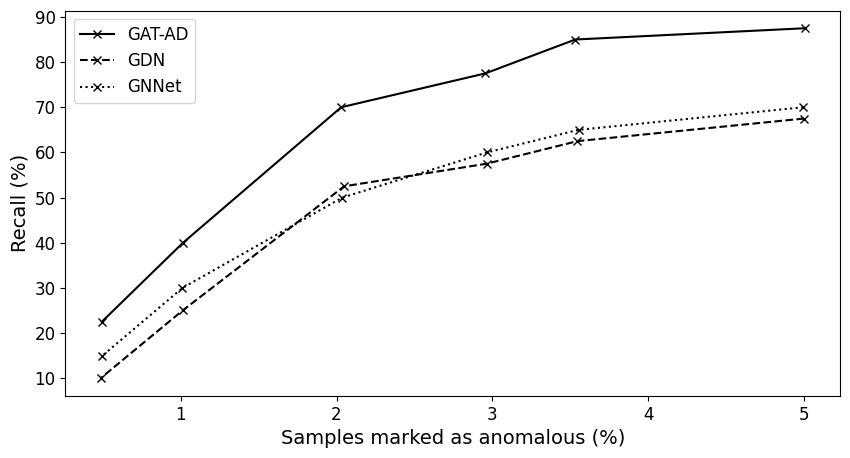

| Model   | Type A anomalies   | Type B anomalies   |
|:--------|:-------------------|:-------------------|
| GAT-AD  | 85.0 \%            | 90.0 \%            |
| GDN     | 70.0 \%            | 65.0 \%            |
| GNNet   | 90.0 \%            | 50.0 \%            |

In [2]:
abilene_anominj = torch.load("../../dataset/Abilene/processed_anominj.pth")
point_inj_anomalies = [(anomaly["source_flow"], anomaly["start"], anomaly["end"]) for anomaly in abilene_anominj["anomaly_metadata"] if anomaly["type"] == "Anomaly in source flow"]
context_inj_anomalies = [(anomaly["source_flow"], anomaly["start"], anomaly["end"]) for anomaly in abilene_anominj["anomaly_metadata"] if anomaly["type"] == "Anomaly in context flows"]

anominj_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
anominj_temp_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = anominj_model["metadata"]["window_size"]
GDN_scores = torch.tensor(torch.load("pth_files/evaluation/3_abilene_classif_performance/GDN_test_scores.pth"))

total_modified_samples = torch.logical_or(torch.logical_or(abilene_anominj["point_anoms"], abilene_anominj["context_anoms"]), abilene_anominj["context_modified_flows"]).nonzero().shape[0]
total_samples = anominj_model["test"].y.shape[0] * anominj_model["test"].y.shape[1]
print(f"Modified samples: {100 * total_modified_samples / total_samples:.2f}%")
GNNet = parse_gnnet_format("pth_files/evaluation/3_abilene_classif_performance/GNNet_Abilene_anominj.pth")

models = {"GAT-AD": anominj_temp_model, "GDN": GDN_scores, "GNNet": GNNet}
# thresholds = {"GAT-AD+": [9, 8.9, 8.7, 8.5, 8.2, 8, 7.5, 6.2, 4.2] # 9.5%, 8.16%, 6.17%, 4.83%, 3.53%, 2.95%, 2.03%, 1.01%, 0.49%
thresholds = {
    "GAT-AD": [1.369, 1.7, 1.9, 2.4, 3.7, 5.7], # 5.00%, 3.53%, 2.95%, 2.03%, 1.01%, 0.49%
    "GDN": [1.685, 2.26, 2.7, 4.1, 9.2, 20],
    "GNNet": [5.5, 6.91, 7.83, 10.3, 18.4, 34.6]
}
# eps = {"GAT-AD+": 0.9, "GAT-AD+ temp": 0.7}
eps = {"GAT-AD": 0.7}
T = 1

def plot_anomalies(model_detections, save_path=None):
    # colors = ['black', 'blue', 'red', 'green', 'purple', 'orange']  # Add more colors if needed
    linestyles = ["-", "--", ":"]
    plt.figure(figsize=(10, 5))

    for idx, (model, data) in enumerate(model_detections.items()):
        x_values = [item[0] for item in data]
        y1_values = [item[1] for item in data]
        y2_values = [item[2] for item in data]
        combined_y_values = [(item[1] + item[2]) / 2 for item in data]
        # color = colors[idx % len(colors)]
        linestyle = linestyles[idx % len(linestyles)]
        marker = "x"

        # plt.plot(x_values, y1_values, marker=marker, linestyle="-", label=f'{model} point anomalies', color=color)
        # plt.plot(x_values, y2_values, marker=marker, linestyle="--", label=f'{model} contextual anomalies', color=color)
        plt.plot(x_values, combined_y_values, marker=marker, linestyle=linestyle, label=f"{model}", color="black")

    plt.xlabel('Samples marked as anomalous (%)', fontsize=14)
    plt.ylabel('Recall (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # plt.title('Anomaly Detection Performance', fontsize=16)
    if save_path:
        plt.savefig(save_path)
    plt.show()

def generate_anomaly_table(model_detections):
    table_data = []
    for model, values in model_detections.items():
        # Get the first tuple (first values)
        first_values = values[0]
        # Unpack the values for Type A and Type B anomalies
        _, type_a_anomalies, type_b_anomalies = first_values
        # Append the model name and the anomaly counts to the table data
        table_data.append([model, f"{type_a_anomalies} \%", f"{type_b_anomalies} \%"])

    # Create the table with headers
    headers = ["Model", "Type A anomalies", "Type B anomalies"]
    table = tabulate(table_data, headers=headers, tablefmt="pipe")

    # Display the table
    display(Markdown(table))

model_detections = {"GAT-AD": [], "GDN": [], "GNNet": []}
for model_name, model in models.items():
    if model_name == "GDN":
        total_samples = GDN_scores.shape[0] * GDN_scores.shape[1]
    else:
        total_samples = model["test"].y.shape[0] * model["test"].y.shape[1]
    for threshold in thresholds[model_name]:
        if model_name == "GDN":
            scores = GDN_scores
        elif model_name == "GNNet":
            scores = calculate_gnnet_scores(model["train"].y[:, -anominj_temp_model["test"].y.shape[1]:],
                                            model["train"].y_hat[:, -anominj_temp_model["test"].y.shape[1]:],
                                            model["test"].y[:, -anominj_temp_model["test"].y.shape[1]:],
                                            model["test"].y_hat[:, -anominj_temp_model["test"].y.shape[1]:])
        else:
            scores = calculate_scores(model_y=model["test"].y[:, -anominj_temp_model["test"].y.shape[1]:],
                                      model_y_hat=model["test"].y_hat[:, -anominj_temp_model["test"].y.shape[1]:],
                                      metric="MAE", eps=eps[model_name])
        detections = scores > threshold
        num_detections = 100 * detections.nonzero().shape[0] / total_samples
        offset = abilene_anominj["paths"].shape[1] - detections.shape[1]
        point_detections, context_detections = [], []
        for i, (flow, start, end) in enumerate(point_inj_anomalies):
            if torch.any(detections[flow, start-offset:end-offset+1]):
                point_detections.append(True)
            else:
                point_detections.append(False)
        for i, (flow, start, end) in enumerate(context_inj_anomalies):
            if torch.any(detections[flow, start-offset:end-offset+1]):
                context_detections.append(True)
            else:
                context_detections.append(False)
        model_detections[model_name].append((num_detections, 100 * sum(point_detections) / 20, 100 * sum(context_detections) / 20))

plot_anomalies(model_detections, save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_anomalies.pdf")
generate_anomaly_table(model_detections=model_detections)

## 3.5) Anomaly visualization

In [12]:
def plot_time_series(GAT_ADp_test_y, GAT_ADp_test_y_hat, labels, nodes_to_plot_indices, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_test_y_subset = GAT_ADp_test_y[:, plot_start:plot_end + 1]
    GAT_ADp_test_y_hat_subset = GAT_ADp_test_y_hat[:, plot_start:plot_end + 1]
    labels_subset = labels[:, plot_start:plot_end + 1]

    fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

    node_idx = nodes_to_plot_indices[0]
    y_true = GAT_ADp_test_y_subset[node_idx].cpu().numpy()
    y_hat_gat = GAT_ADp_test_y_hat_subset[node_idx].cpu().numpy()

    # Plot the node data
    axs.plot(adjusted_time_range, y_true, label='Ground truth', color='black')
    axs.plot(adjusted_time_range, y_hat_gat, label='GAT-AD+ prediction', color='black', linestyle='--')

    # Highlight the background for label == 1
    contiguous_regions = []
    in_region = False
    region_start = 0
    for i in adjusted_time_range:
        if labels_subset[node_idx, i] == 1 and not in_region:
            in_region = True
            region_start = i
        elif labels_subset[node_idx, i] == 0 and in_region:
            in_region = False
            contiguous_regions.append((region_start, i))
    if in_region:
        contiguous_regions.append((region_start, adjusted_time_range[-1] + 1))
    for start, end in contiguous_regions:
        axs.axvspan(start, end, color='grey', alpha=0.3)

    # Calculate mean value for the rest of the nodes
    if len(nodes_to_plot_indices) > 1:
        rest_indices = nodes_to_plot_indices[1:]
        y_hat_mean = GAT_ADp_test_y_hat_subset[rest_indices, :].mean(dim=0).cpu().numpy()
        axs.plot(adjusted_time_range, y_hat_mean, label='Context mean value', color='grey', linestyle='-')

    axs.set_ylabel('Flow measurement', fontsize=14)
    axs.set_xlabel('Sample', fontsize=14)
    axs.legend(loc='upper right', fontsize=12)
    axs.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_time_series_context(GAT_ADp_test_y, GAT_ADp_test_y_hat, GAT_ADp_prev_context, labels, source_flow, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_test_y_subset = GAT_ADp_test_y[:, plot_start:plot_end + 1]
    GAT_ADp_test_y_hat_subset = GAT_ADp_test_y_hat[:, plot_start:plot_end + 1]
    prev_context = GAT_ADp_prev_context.unsqueeze(0).repeat(plot_end-plot_start+1, 1)  # median values of alphas before the anomaly
    pred_context = GAT_ADp_test_y_subset * prev_context.T
    pred_context = pred_context.sum(dim=0)
    labels_subset = labels[:, plot_start:plot_end + 1]

    fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

    node_idx = source_flow
    y_true = GAT_ADp_test_y_subset[node_idx].cpu().numpy()
    y_hat_gat = GAT_ADp_test_y_hat_subset[node_idx].cpu().numpy()

    # Plot the node data
    axs.plot(adjusted_time_range, y_true, label='Target flow', color='black')
    # axs.plot(adjusted_time_range, y_hat_gat, label='GAT-AD+ prediction', color='black', linestyle='--')
    axs.plot(adjusted_time_range, pred_context, label="Predicted context", color="black", linestyle="--")

    # Highlight the background for label == 1
    contiguous_regions = []
    in_region = False
    region_start = 0
    for i in adjusted_time_range:
        if labels_subset[node_idx, i] == 1 and not in_region:
            in_region = True
            region_start = i
        elif labels_subset[node_idx, i] == 0 and in_region:
            in_region = False
            contiguous_regions.append((region_start, i))
    if in_region:
        contiguous_regions.append((region_start, adjusted_time_range[-1] + 1))
    for start, end in contiguous_regions:
        axs.axvspan(start, end, color='grey', alpha=0.3)

    axs.set_ylabel('Measurement', fontsize=14)
    axs.set_xlabel('Sample', fontsize=14)
    axs.legend(loc='upper right', fontsize=12)
    axs.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_time_series_scores(GAT_ADp_scores, GDN_scores, labels, nodes_to_plot_indices, abilene_index_to_name, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    GAT_ADp_range_score = GAT_ADp_scores[:, plot_start:plot_end + 1]
    GDN_range_score = GDN_scores[:, plot_start:plot_end + 1]
    labels_subset = labels[:, plot_start:plot_end + 1]

    num_plots = len(nodes_to_plot_indices)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots), sharex=True)

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax, node_idx in zip(axs, nodes_to_plot_indices):
        score_gat = GAT_ADp_range_score[node_idx].cpu().numpy()
        score_gdn = GDN_range_score[node_idx].cpu().numpy()

        # Plot the node data
        ax.plot(adjusted_time_range, score_gat, label='GAT-AD+ score', color='green')
        ax.plot(adjusted_time_range, score_gdn, label='GDN score', color='red')

        # Highlight the background for label == 1
        for i in adjusted_time_range:
            if labels_subset[node_idx, i] == 1:
                ax.axvspan(i, i + 1, color='lightcoral', alpha=0.3)

        # ax.set_ylabel(f'Node {abilene_index_to_name[node_idx]}')
        ax.set_ylabel(f'Flow demand')
        ax.legend(loc='upper right')
        # ax.grid(True)

    axs[-1].set_xlabel('Sample')
    plt.title("Model anomaly scores")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_alphas(GAT_ADp_alphas, nodes_to_plot_indices, context_node_indices, abilene_index_to_name, plot_start, plot_end, save_path=None):
    GAT_ADp_range_alphas = GAT_ADp_alphas[plot_start:plot_end, :, :]
    num_plots = len(nodes_to_plot_indices)

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots))

    # In case there's only one node to plot, axs is not a list but a single Axes object
    if num_plots == 1:
        axs = [axs]

    for ax, node_idx in zip(axs, nodes_to_plot_indices):
        node_alphas_values, node_alphas_indices = GAT_ADp_range_alphas[:, node_idx, :].mean(dim=0).sort(descending=True)
        node_alphas_values = node_alphas_values[:7].numpy()
        colors = ['black' if index in context_node_indices else 'grey' for index in node_alphas_indices[:7]]
        node_alphas_indices = [abilene_index_to_name[index] for index in node_alphas_indices[:7].numpy()]

        ax.bar(node_alphas_indices, node_alphas_values, color=colors)

        ax.set_xticks(range(len(node_alphas_indices)))
        ax.set_xticklabels(node_alphas_indices, rotation=0, fontsize=9)
        ax.set_ylabel('Attention score', fontsize=12)
        ax.tick_params(axis='y', which='major', labelsize=12)

    black_patch = mpatches.Patch(color='black', label='Flow in original context')
    grey_patch = mpatches.Patch(color='grey', label='Flow not in original context')
    plt.legend(handles=[black_patch, grey_patch], loc='upper right', fontsize=12)

    if save_path:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()


def plot_score(scores, source_flow, thresholds, abilene_labels, models, plot_start, plot_end, save_path=None):
    adjusted_time_range = range(0, plot_end - plot_start + 1)
    wadi_labels_subset = abilene_labels[source_flow, plot_start:plot_end + 1]

    plt.figure(figsize=(10, 4))
    ax = plt.gca()

    # Define different linestyles
    linestyles = ['--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]  # Extend this list if needed

    # Plot each score series normalized by its corresponding threshold
    for idx, (score, threshold, model) in enumerate(zip(scores, thresholds, models)):
        scores_subset = score[source_flow, plot_start:plot_end + 1]
        normalized_scores = scores_subset / threshold
        ax.plot(adjusted_time_range, normalized_scores, label=f'{model} scores', linestyle=linestyles[idx % len(linestyles)], color='black')

    # Highlight the background for label == 1
    contiguous_regions = []
    in_region = False
    region_start = 0

    for i in adjusted_time_range:
        if wadi_labels_subset[i] == 1 and not in_region:
            in_region = True
            region_start = i
        elif wadi_labels_subset[i] == 0 and in_region:
            in_region = False
            contiguous_regions.append((region_start, i))
    if in_region:
        contiguous_regions.append((region_start, adjusted_time_range[-1] + 1))

    for start, end in contiguous_regions:
        ax.axvspan(start, end, color='grey', alpha=0.3)

    # Add a horizontal line for the threshold
    ax.axhline(y=1, color='black', linestyle='-', label='Threshold')

    # Set plot labels and title with increased font sizes
    ax.set_xlabel('Sample', fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

### 3.5.1) Contextual anomaly

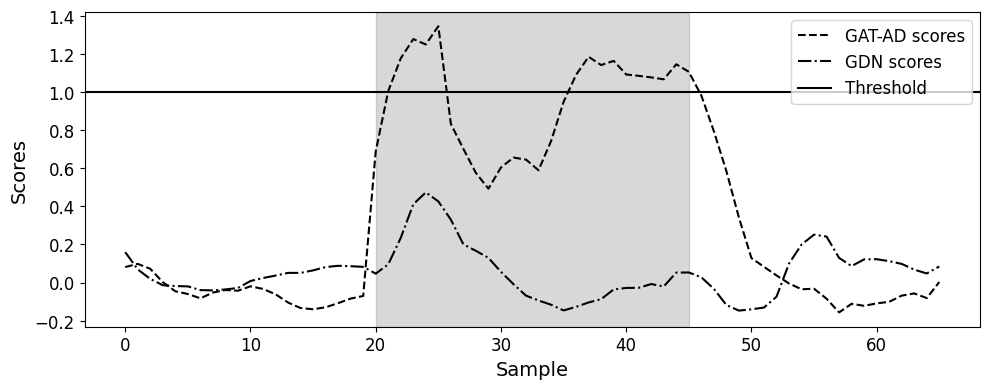

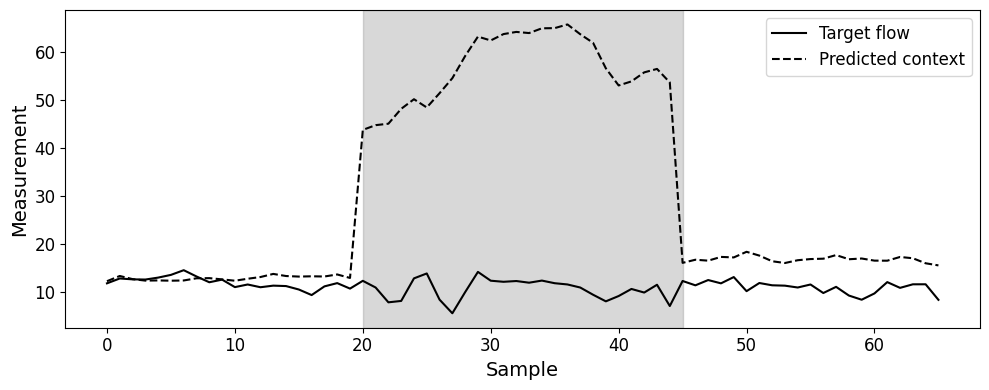

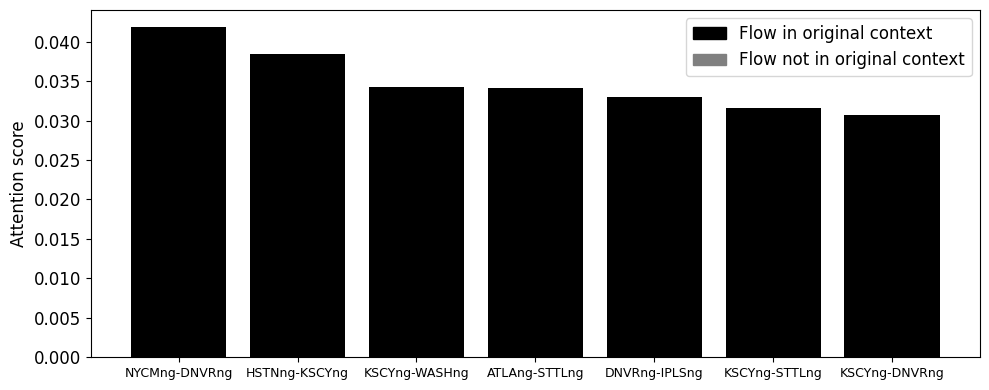

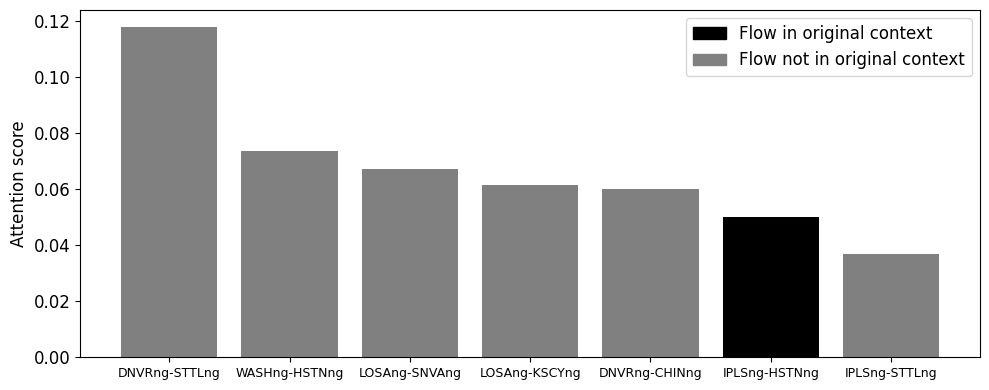

In [13]:
abilene = torch.load("../../dataset/Abilene/processed_anominj.pth")
abilene_path_to_index = abilene["path_indices"]
abilene_index_to_name = {v: f"{k[0]}-{k[1]}" for k, v in abilene_path_to_index.items()}

anominj_temp_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = 100
context_anomalies = [(anomaly["source_flow"], anomaly["context"], anomaly["start"], anomaly["end"]) for anomaly in abilene["anomaly_metadata"] if anomaly["type"] == "Anomaly in context flows"]

thresholds = {
    "GAT-AD": [1.4, 1.7, 1.9, 2.4, 3.7, 5.7], # 4.83%, 3.53%, 2.95%, 2.03%, 1.01%, 0.49%
    "GDN": [1.74, 2.3, 2.7, 4.1, 9.2, 20],
    "GNNet": [5.63, 6.9, 7.9, 10.3, 18.4, 34.6]
}
offset = abilene["paths"].shape[1] - anominj_temp_model["test"].y.shape[1]

anomaly_id = 18
source_flow, context, start, end = context_anomalies[anomaly_id]
GAT_ADp_scores = calculate_scores(model_y=anominj_temp_model["test"].y, model_y_hat=anominj_temp_model["test"].y_hat, metric="MAE", eps=0.7)
GDN_scores = torch.tensor(torch.load("pth_files/evaluation/3_abilene_classif_performance/GDN_test_scores.pth"))[:, window_size - 11:]
scores = [GAT_ADp_scores, GDN_scores]
thresholds = [thresholds["GAT-AD"][3], thresholds["GDN"][3]]
models = ["GAT-AD", "GDN"]
plot_score(scores=scores, source_flow=source_flow, thresholds=thresholds,
           abilene_labels=abilene["context_anoms"][:, -anominj_temp_model["test"].y.shape[1]:], models=models, plot_start=start-offset-20, plot_end=end-offset+20,
           save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeB_anomaly_scores.pdf")
margins = 100

# plot_time_series(GAT_ADp_test_y=anominj_temp_model["test"].y, GAT_ADp_test_y_hat=anominj_temp_model["test"].y_hat,
#                  labels=abilene["context_anoms"][:, -anominj_temp_model["test"].y.shape[1]:],
#                  nodes_to_plot_indices=[source_flow] + context, plot_start=start-offset-20, plot_end=end-offset+20,
#                  save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_contextual_anomaly.pdf")
plot_time_series_context(GAT_ADp_test_y=anominj_temp_model["test"].y, GAT_ADp_test_y_hat=anominj_temp_model["test"].y_hat,
                         GAT_ADp_prev_context=anominj_temp_model["test"].alphas[start-offset-margins:start-offset, source_flow, :].mean(dim=0), labels=abilene["context_anoms"][:, -anominj_temp_model["test"].y.shape[1]:],
                         source_flow=source_flow, plot_start=start-offset-20, plot_end=end-offset+20,
                         save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeB_anomaly.pdf")
plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
            abilene_index_to_name=abilene_index_to_name, plot_start=start-offset-margins, plot_end=start-offset,
            save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeB_anomaly_context_before.pdf")
plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
            abilene_index_to_name=abilene_index_to_name, plot_start=start-offset, plot_end=end-offset,
            save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeB_anomaly_context_during.pdf")
# plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
#             abilene_index_to_name=abilene_index_to_name, plot_start=end-offset, plot_end=end-offset+margins,
#             anomaly_type="contextual", save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_contextual_anomaly_context_after.pdf")

### 3.5.2) Point anomaly

In [7]:
def calculate_similarity(args):
    i, data_i, data = args
    node_similarity = []

    # Calculate DTW distance between the current node and all other nodes
    for j, data_j in enumerate(data):
        if i != j:  # Exclude self-similarity
            distance, _ = fastdtw(data_i, data_j)
            node_similarity.append((distance, j))

    # Sort the node similarity list based on DTW distance
    node_similarity.sort()
    return node_similarity

# multiprocessing version
def compute_similarities(data):
    num_nodes = len(data)
    node_similarities = []

    with get_context("fork").Pool() as pool:
        args = [(i, data[i], data) for i in range(num_nodes)]
        node_similarities = list(pool.imap(calculate_similarity, args))

    return node_similarities

def find_most_similar_nodes(data):
    node_similarities = compute_similarities(data)
    most_similar_nodes = []
    for i, node_similarity in enumerate(node_similarities):
        # Select the 3 most similar nodes
        # most_similar = [node[1] for node in node_similarity[:3]]
        # most_similar_nodes.append((i, most_similar, sum(node[0] for node in node_similarity[:3]) / 3))
        # Select the most similar nodes based on the mean
        cut = torch.tensor([similarity for similarity, flow_index in node_similarity])
        flow_indices = torch.tensor([flow_index for similarity, flow_index in node_similarity])
        most_similar_nodes.append((i, flow_indices[cut < cut.mean() / 2].tolist()))

    return most_similar_nodes

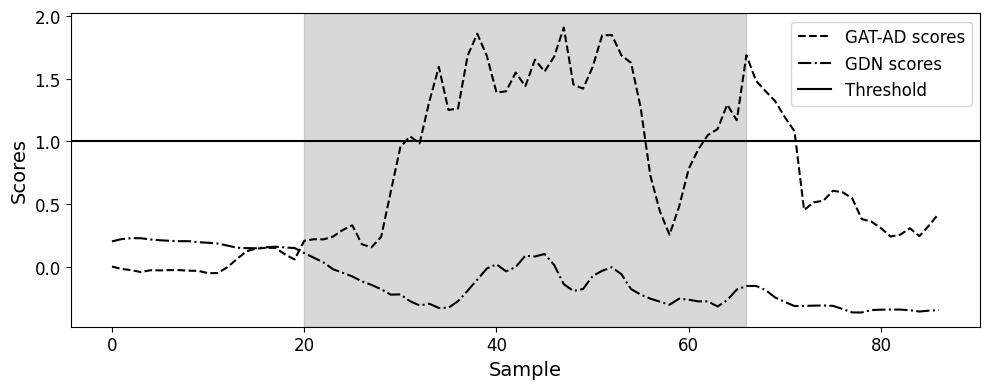

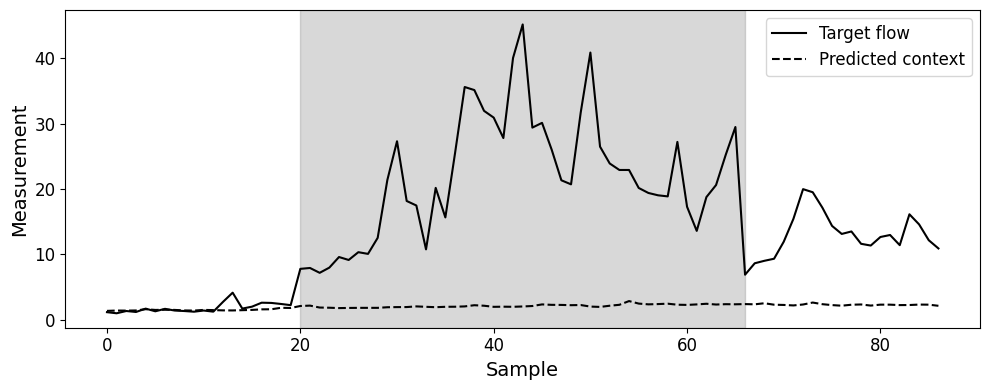

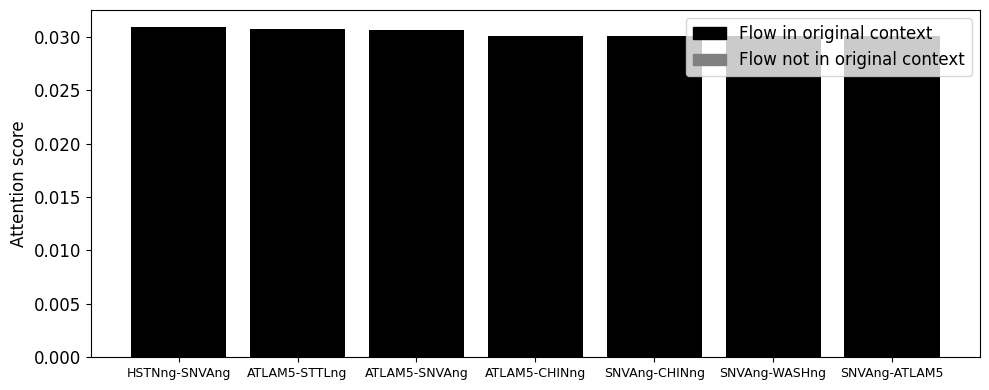

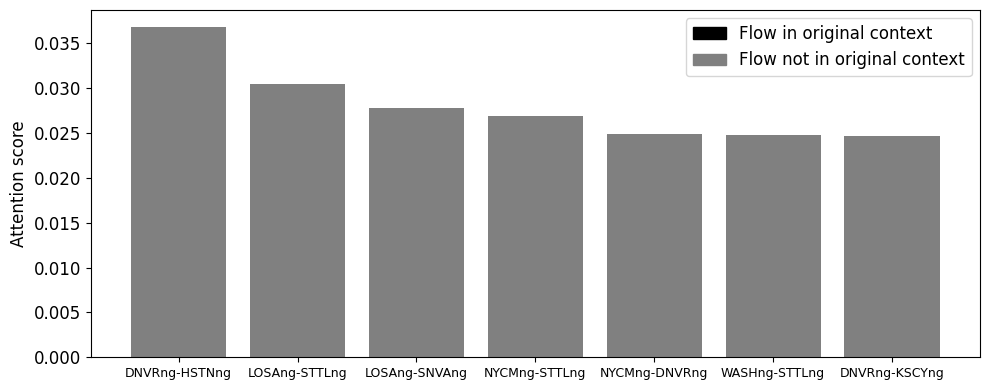

In [14]:
original_abilene = torch.load("../../dataset/Abilene/processed.pth")
original_flows = original_abilene["paths"]

abilene = torch.load("../../dataset/Abilene/processed_anominj.pth")
abilene_path_to_index = abilene["path_indices"]
abilene_index_to_name = {v: f"{k[0]}-{k[1]}" for k, v in abilene_path_to_index.items()}

anominj_temp_model = torch.load("pth_files/evaluation/3_abilene_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = 100
point_anomalies = [(anomaly["source_flow"], anomaly["start"], anomaly["end"]) for anomaly in abilene["anomaly_metadata"] if anomaly["type"] == "Anomaly in source flow"]

thresholds = {
    "GAT-AD": [1.4, 1.7, 1.9, 2.4, 3.7, 5.7], # 4.83%, 3.53%, 2.95%, 2.03%, 1.01%, 0.49%
    "GDN": [1.74, 2.3, 2.7, 4.1, 9.2, 20],
    "GNNet": [5.63, 6.9, 7.9, 10.3, 18.4, 34.6]
}
offset = abilene["paths"].shape[1] - anominj_temp_model["test"].y.shape[1]

anomaly_id = 11

source_flow, start, end = point_anomalies[anomaly_id]
context = find_most_similar_nodes(original_flows[:, start:end])[source_flow][1]
GAT_ADp_scores = calculate_scores(model_y=anominj_temp_model["test"].y, model_y_hat=anominj_temp_model["test"].y_hat, metric="MAE", eps=0.7)
GDN_scores = torch.tensor(torch.load("pth_files/evaluation/3_abilene_classif_performance/GDN_test_scores.pth"))[:, window_size - 11:]
scores = [GAT_ADp_scores, GDN_scores]
model_thresholds = [thresholds["GAT-AD"][3], thresholds["GDN"][3]]
models = ["GAT-AD", "GDN"]
plot_score(scores=scores, source_flow=source_flow, thresholds=model_thresholds,
        abilene_labels=abilene["point_anoms"][:, -anominj_temp_model["test"].y.shape[1]:], models=models, plot_start=start-offset-20, plot_end=end-offset+20,
        save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeA_anomaly_scores.pdf")
margins = 100

# plot_time_series(GAT_ADp_test_y=anominj_temp_model["test"].y, GAT_ADp_test_y_hat=anominj_temp_model["test"].y_hat,
#                  GAT_ADp_alphas=anominj_temp_model["test"].alphas, labels=abilene["point_anoms"][:, -anominj_temp_model["test"].y.shape[1]:],
#                  nodes_to_plot_indices=[source_flow] + context, plot_start=start-offset-20, plot_end=end-offset+20,
#                 save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_point_anomaly_scores.pdf")
plot_time_series_context(GAT_ADp_test_y=anominj_temp_model["test"].y, GAT_ADp_test_y_hat=anominj_temp_model["test"].y_hat,
                         GAT_ADp_prev_context=anominj_temp_model["test"].alphas[start-offset-margins:start-offset, source_flow, :].mean(dim=0), labels=abilene["point_anoms"][:, -anominj_temp_model["test"].y.shape[1]:],
                         source_flow=source_flow, plot_start=start-offset-20, plot_end=end-offset+20,
                         save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeA_anomaly.pdf")
plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
            abilene_index_to_name=abilene_index_to_name, plot_start=start-offset-margins, plot_end=start-offset,
            save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeA_anomaly_context_before.pdf")
plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
            abilene_index_to_name=abilene_index_to_name, plot_start=start-offset, plot_end=end-offset,
            save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_typeA_anomaly_context_during.pdf")
# plot_alphas(GAT_ADp_alphas=anominj_temp_model["test"].alphas, nodes_to_plot_indices=[source_flow], context_node_indices=context,
#             abilene_index_to_name=abilene_index_to_name, plot_start=end-offset, plot_end=end-offset+margins,
#             anomaly_type="point", save_path=r"/Users/hlatif/PhD/Papers/4. Computers and Industrial Engineering24/Images/Injected_point_anomaly_context_after.pdf")

# 4) Model design analysis

## 4.1) Find optim parameters

In [28]:
MPNN_AD = torch.load("pth_files/evaluation/4_model_design_analysis/MPNN_AD_ws100.pth", map_location=torch.device("cpu"))
GAT_AD = torch.load("pth_files/evaluation/4_model_design_analysis/GAT_AD_ws100.pth", map_location=torch.device("cpu"))
GAT_ADp_readout = torch.load("pth_files/evaluation/4_model_design_analysis/GAT_ADp_readout_ws100.pth", map_location=torch.device("cpu"))
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"]
models = {"MPNN_AD": MPNN_AD, "GAT_AD": GAT_AD, "GAT_AD+ readout": GAT_ADp_readout, "GAT_AD+": GAT_ADp}

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    ground_truth = wadi_labels[window_size:]
    max_f1 = 0
    optim_eps = 0
    for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
        scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps)
        optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=5000)
        detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
        precision, recall, f1 = calculate_metrics(ground_truth=ground_truth, predictions=detections)
        if f1 > max_f1:
            max_f1 = f1
            optim_eps = eps
    print(f"Model {model_name} optim eps: {optim_eps} (F1={max_f1:.2f}%)")

Model MPNN_AD optim eps: 0.9 (F1=34.75%)
Model GAT_AD optim eps: 0.4 (F1=56.97%)
Model GAT_ADp_readout optim eps: 0.1 (F1=26.47%)
Model GAT_ADp optim eps: 0.05 (F1=58.36%)


## 4.2) Run with optim parameters

In [3]:
MPNN_AD = torch.load("pth_files/evaluation/4_model_design_analysis/MPNN_AD_ws100.pth", map_location=torch.device("cpu"))
GAT_AD = torch.load("pth_files/evaluation/4_model_design_analysis/GAT_AD_ws100.pth", map_location=torch.device("cpu"))
GAT_ADp_readout = torch.load("pth_files/evaluation/4_model_design_analysis/GAT_ADp_readout_ws100.pth", map_location=torch.device("cpu"))
GAT_ADp = torch.load("pth_files/evaluation/1_classif_performance/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"]

def calculate_mre(y_true, y_pred, eps=1e-2):
    absolute_error = torch.abs(y_true - y_pred)
    relative_error = absolute_error / (torch.abs(y_true) + eps)
    mre = torch.mean(relative_error, dim=1)  # Mean relative error for each node
    return mre

models = {"MPNN_AD": MPNN_AD, "GAT_AD": GAT_AD, "GAT_AD+ readout": GAT_ADp_readout, "GAT_AD+": GAT_ADp}
eps = {"MPNN_AD": 0.9, "GAT_AD": 0.4, "GAT_AD+ readout": 0.1, "GAT_AD+": 0.05}
table_data = []

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    ground_truth = wadi_labels[window_size:]
    scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps[model_name])
    optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=5000)
    detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
    precision, recall, f1, accuracy = calculate_metrics(ground_truth=ground_truth, predictions=detections, return_accuracy=True)
    mre = calculate_mre(model["test"].y, model["test"].y_hat).mean().item() * 100
    table_data.append([model_name, f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{mre:.2f}%", f"{accuracy:.2f}%"])
latex_table = tabulate(table_data, headers=["Model", "Precision", "Recall", "F1", "MRE", "Accuracy"], tablefmt="pipe")
display(Markdown(latex_table))

# print(tabulate(table_data, headers=["Model", "Precision", "Recall", "F1"], tablefmt="latex"))

| Model           | Precision   | Recall   | F1     | MRE        | Accuracy   |
|:----------------|:------------|:---------|:-------|:-----------|:-----------|
| MPNN_AD         | 51.70%      | 26.17%   | 34.75% | 20.58%     | 94.36%     |
| GAT_AD          | 81.78%      | 43.71%   | 56.97% | 122.19%    | 96.21%     |
| GAT_AD+ readout | 90.48%      | 15.42%   | 26.34% | 809775.20% | 95.05%     |
| GAT_AD+         | 81.87%      | 45.33%   | 58.36% | 18.80%     | 96.29%     |

# 5) Sensitivity analyis: window size and temperature

## 5.1) Find optim parameters

In [4]:
ws_100 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
ws_200 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws200.pth", map_location=torch.device("cpu"))
ws_400 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws400.pth", map_location=torch.device("cpu"))
ws_800 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws800.pth", map_location=torch.device("cpu"))
ws_100_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
ws_200_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws200_temp.pth", map_location=torch.device("cpu"))
ws_400_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws400_temp.pth", map_location=torch.device("cpu"))
ws_800_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws800_temp.pth", map_location=torch.device("cpu"))
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"]
models = {"WS=100": ws_100, "WS=200": ws_200, "WS=400": ws_400, "WS=800": ws_800, "WS=100 (temp)": ws_100_temp, "WS=200 (temp)": ws_200_temp, "WS=400 (temp)": ws_400_temp, "WS=800 (temp)": ws_800_temp}

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    ground_truth = wadi_labels[window_size:]
    max_f1 = 0
    optim_eps = 0
    for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
        scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps)
        optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=5000)
        detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
        precision, recall, f1 = calculate_metrics(ground_truth=ground_truth, predictions=detections)
        if f1 > max_f1:
            max_f1 = f1
            optim_eps = eps
    print(f"Model {model_name} optim eps: {optim_eps} (F1={max_f1:.2f}%)")

Model WS=100 optim eps: 0.8 (F1=55.57%)
Model WS=200 optim eps: 0.8 (F1=49.97%)
Model WS=400 optim eps: 0.7 (F1=45.22%)
Model WS=800 optim eps: 0.2 (F1=46.07%)
Model WS=100 (temp) optim eps: 0.05 (F1=58.36%)
Model WS=200 (temp) optim eps: 0.1 (F1=51.13%)
Model WS=400 (temp) optim eps: 0.5 (F1=45.05%)
Model WS=800 (temp) optim eps: 0.08 (F1=53.00%)


## 5.2) Run with optim parameters

In [9]:
ws_100 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
ws_200 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws200.pth", map_location=torch.device("cpu"))
ws_400 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws400.pth", map_location=torch.device("cpu"))
ws_800 = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws800.pth", map_location=torch.device("cpu"))
ws_100_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
ws_200_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws200_temp.pth", map_location=torch.device("cpu"))
ws_400_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws400_temp.pth", map_location=torch.device("cpu"))
ws_800_temp = torch.load("pth_files/evaluation/5_window_size_analysis/GAT_ADp_ws800_temp.pth", map_location=torch.device("cpu"))
wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"]
models = {"WS=100": ws_100, "WS=100 (temp)": ws_100_temp, "WS=200": ws_200, "WS=200 (temp)": ws_200_temp, "WS=400": ws_400, "WS=400 (temp)": ws_400_temp, "WS=800": ws_800, "WS=800 (temp)": ws_800_temp}
eps = {"WS=100": 0.8, "WS=200": 0.8, "WS=400": 0.7, "WS=800": 0.2, "WS=100 (temp)": 0.05, "WS=200 (temp)": 0.1, "WS=400 (temp)": 0.5, "WS=800 (temp)": 0.08}
table_data = []

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    ground_truth = wadi_labels[window_size:]
    scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps[model_name])
    optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=5000)
    detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
    precision, recall, f1 = calculate_metrics(ground_truth=ground_truth, predictions=detections)
    table_data.append([model_name, f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
latex_table = tabulate(table_data, headers=["Window size", "Precision", "Recall", "F1"], tablefmt="pipe")
display(Markdown(latex_table))

print(tabulate(table_data, headers=["Window size", "Precision", "Recall", "F1"], tablefmt="latex"))

| Window size   | Precision   | Recall   | F1     |
|:--------------|:------------|:---------|:-------|
| WS=100        | 76.88%      | 43.51%   | 55.57% |
| WS=100 (temp) | 81.87%      | 45.33%   | 58.36% |
| WS=200        | 64.27%      | 40.87%   | 49.97% |
| WS=200 (temp) | 64.65%      | 42.29%   | 51.13% |
| WS=400        | 73.52%      | 32.66%   | 45.22% |
| WS=400 (temp) | 49.57%      | 41.28%   | 45.05% |
| WS=800        | 93.41%      | 30.58%   | 46.07% |
| WS=800 (temp) | 69.25%      | 42.93%   | 53.00% |

\begin{tabular}{llll}
\hline
 Window size   & Precision   & Recall   & F1     \\
\hline
 WS=100        & 76.88\%      & 43.51\%   & 55.57\% \\
 WS=100 (temp) & 81.87\%      & 45.33\%   & 58.36\% \\
 WS=200        & 64.27\%      & 40.87\%   & 49.97\% \\
 WS=200 (temp) & 64.65\%      & 42.29\%   & 51.13\% \\
 WS=400        & 73.52\%      & 32.66\%   & 45.22\% \\
 WS=400 (temp) & 49.57\%      & 41.28\%   & 45.05\% \\
 WS=800        & 93.41\%      & 30.58\%   & 46.07\% \\
 WS=800 (temp) & 69.25\%      & 42.93\%   & 53.00\% \\
\hline
\end{tabular}


# 6) Reduced training (only first 10% of training samples)

## 6.1) Reduce training data

In [18]:
wadi = torch.load("../../dataset/WADI/processed.pth")
wadi_train_GDN = pd.read_csv("pth_files/evaluation/6_reduced_training/gdn_train.csv")
wadi_train = wadi["train"]
num_samples = wadi_train.shape[1] // 10

shortened_wadi_train_GDN = wadi_train_GDN.iloc[0:num_samples]
shortened_wadi_train = wadi_train[:, 0:num_samples]

wadi["train"] = shortened_wadi_train
wadi["comment"] = wadi["comment"] + " (shortened to cointain the first 10% of training data only)"
torch.save(wadi, "pth_files/evaluation/6_reduced_training/processed_shorttrain.pth")
shortened_wadi_train_GDN.to_csv("pth_files/evaluation/6_reduced_training/gdn_shorttrain.csv", index=False)

## 6.2) Find optim parameters

In [2]:
ws_100 = torch.load("pth_files/evaluation/6_reduced_training/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
ws_100_temp = torch.load("pth_files/evaluation/6_reduced_training/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))

wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"]
models = {"WS=100": ws_100, "WS=100 (temp)": ws_100_temp}

for model_name, model in models.items():
    window_size = model["metadata"]["window_size"]
    ground_truth = wadi_labels[window_size:]
    max_f1 = 0
    optim_eps = 0
    for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
        scores = calculate_scores(model_y=model["test"].y, model_y_hat=model["test"].y_hat, metric="MAE", eps=eps)
        optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=2000)
        detections = scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
        precision, recall, f1 = calculate_metrics(ground_truth=ground_truth, predictions=detections)
        if f1 > max_f1:
            max_f1 = f1
            optim_eps = eps
    print(f"Model {model_name} optim eps: {optim_eps} (F1={max_f1:.2f}%)")

window_size = ws_100["metadata"]["window_size"]
ground_truth = wadi_labels[window_size:]
gnnet = parse_gnnet_format("pth_files/evaluation/6_reduced_training/GNNet_WADI_shortrain.pth")
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
_, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=scores, ground_truth_labels=ground_truth, num_iters=2000, topk=1)
print(f"Model GNNet optim thresh: {optim_thresh} (F1={f1:.2f}%)")

Model WS=100 optim eps: 0.07 (F1=40.41%)
Model WS=100 (temp) optim eps: 0.6 (F1=51.46%)
Model GNNet optim thresh: 114741.4375 (F1=22.48%)


## 6.3) Run with optim parameters

In [5]:
ws_100 = torch.load("pth_files/evaluation/6_reduced_training/GAT_ADp_ws100.pth", map_location=torch.device("cpu"))
GAT_ADp = torch.load("pth_files/evaluation/6_reduced_training/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = GAT_ADp["metadata"]["window_size"]
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat

wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:]
table_data = []

GAT_ADp_scores = calculate_scores(model_y=GAT_ADp_y, model_y_hat=GAT_ADp_y_hat, metric="MAE", eps=0.8)
optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=GAT_ADp_scores, ground_truth_labels=wadi_labels, num_iters=5000)
GAT_ADp_detections = GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=GAT_ADp_detections, return_accuracy=True)
table_data.append(["GAT-AD+", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])
detections = dict(detections=GAT_ADp_detections, threshold=optim_thresh, topk=optim_topk, metric="MAE", eps=0.8, scores=GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0))
torch.save(GAT_ADp_detections, "pth_files/evaluation/6_reduced_training/GAT_ADp_detections.pth")

GDN_detections = torch.tensor(torch.load("pth_files/evaluation/6_reduced_training/GDN_pred_labels.pth")[window_size - 5:])
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=GDN_detections, return_accuracy=True)
table_data.append(["GDN", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])

window_size = ws_100["metadata"]["window_size"]
gnnet = parse_gnnet_format("pth_files/evaluation/6_reduced_training/GNNet_WADI_shortrain.pth")
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
gnnet_detections = scores.topk(dim=0, k=1).values.sum(dim=0) > 114741.4375
precision, recall, f1, accuracy = calculate_metrics(ground_truth=wadi_labels, predictions=gnnet_detections, return_accuracy=True)
table_data.append(["GNNet", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%", f"{accuracy:.2f}%"])

latex_table = tabulate(table_data, headers=["Model", "Precision", "Recall", "F1", "Accuracy"], tablefmt="pipe")
display(Markdown(latex_table))

| Model   | Precision   | Recall   | F1     | Accuracy   |
|:--------|:------------|:---------|:-------|:-----------|
| GAT-AD+ | 73.95%      | 39.45%   | 51.46% | 95.73%     |
| GDN     | 84.79%      | 33.37%   | 47.89% | 95.83%     |
| GNNet   | 99.21%      | 12.68%   | 22.48% | 94.98%     |

## 6.4) Run with optim parameters. Consider the entire interval detected if one of its samples is detected

In [6]:
GAT_ADp = torch.load("pth_files/evaluation/6_reduced_training/GAT_ADp_ws100_temp.pth", map_location=torch.device("cpu"))
window_size = GAT_ADp["metadata"]["window_size"]
GAT_ADp_y = GAT_ADp["test"].y
GAT_ADp_y_hat = GAT_ADp["test"].y_hat

wadi_labels = torch.load("../../dataset/WADI/processed.pth")["test_labels"][window_size:]
table_data = []
T=1

GAT_ADp_scores = calculate_scores(model_y=GAT_ADp_y, model_y_hat=GAT_ADp_y_hat, metric="MAE", eps=0.8)
optim_topk, optim_thresh, precision, recall, f1 = find_opt_thresh(scores=GAT_ADp_scores, ground_truth_labels=wadi_labels, num_iters=5000)
GAT_ADp_detections = GAT_ADp_scores.topk(dim=0, k=optim_topk).values.sum(dim=0) > optim_thresh
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=GAT_ADp_detections, T=T)
precision, recall, f1 = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections)
table_data.append(["GAT-AD+", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])

GDN_detections = torch.tensor(torch.load("pth_files/evaluation/6_reduced_training/GDN_pred_labels.pth")[window_size - 5:])
precision, recall, f1 = calculate_metrics(ground_truth=wadi_labels, predictions=GDN_detections)
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=GDN_detections, T=T)
precision, recall, f1 = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections)
table_data.append(["GDN", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])

window_size = ws_100["metadata"]["window_size"]
gnnet = parse_gnnet_format("pth_files/evaluation/6_reduced_training/GNNet_WADI_shortrain.pth")
scores = calculate_gnnet_scores(gnnet["train"].y, gnnet["train"].y_hat, gnnet["test"].y, gnnet["test"].y_hat)[:, window_size:]
gnnet_detections = scores.topk(dim=0, k=1).values.sum(dim=0) > 114741.4375
_, interval_detections = detect_anomalous_intervals(ground_truth=wadi_labels, predictions=gnnet_detections, T=T)
precision, recall, f1 = calculate_metrics(ground_truth=wadi_labels, predictions=interval_detections)
table_data.append(["GNNet", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])

latex_table = tabulate(table_data, headers=["Model", "Precision", "Recall", "F1"], tablefmt="pipe")
display(Markdown(latex_table))

| Model   | Precision   | Recall   | F1     |
|:--------|:------------|:---------|:-------|
| GAT-AD+ | 87.03%      | 93.20%   | 90.01% |
| GDN     | 89.17%      | 49.29%   | 63.49% |
| GNNet   | 99.37%      | 15.92%   | 27.45% |